# CIFAR10 Classifier: PyTorch + Ray Tune Edition

## Objective

Explore Ray Tune and in the process attempt to to find a better set of hyperparameters that can beat the best test acurracy:
- Resnet 50 as backbone
- Minimal augmentation
- Tracking on Tensorboard

Most of the content is similar to the TensorFlow version of Ray Tune.

---
Date: 24-Oct-2020 | Author: Katnoria

# 1. Setup Imports

In [1]:
import os
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import DataLoader, random_split

# Ray
import ray
from ray import tune
# from ray.tune.integration.torch import 
from ray.tune.schedulers import ASHAScheduler

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [4]:
print("Version Used in this Notebook:")
version_info(torch)
version_info(np)
import matplotlib as mpl
version_info(mpl)
import tqdm as tq
version_info(tq)
version_info(ray)

Version Used in this Notebook:
torch: 1.6.0
numpy: 1.18.5
matplotlib: 3.3.2
tqdm: 4.48.2
ray: 1.0.0


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# 2. Dataset

In this section, we setup the train and test dataloaders. The `Trainable` class will make use of the data loaders defined here.

In [6]:
# Hyper params
BATCH_SIZE=128
NUM_WORKERS=12

In [7]:
# We are not using any augmentations here
# Uncomment Random*
def load_data(batch_size=32, num_workers=1):
    # Setup transforms
    transform = transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(0.2),
        transforms.ToTensor(),
        transforms.Normalize(tuple([0.5]*3), tuple([0.5]*3))
    ])
    # Load the dataset
    train_ds = datasets.CIFAR10(
        root="./data", train=True, 
        download=True, transform=transform
    )
    # Create train and validation splits
    train, val = random_split(train_ds, [45000, 5000])
    # Create data loaders
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_ds = datasets.CIFAR10(
        root="./data", train=False, 
        download=True, transform=transform
    )

    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, test_loader

In [8]:
train_loader, test_loader = load_data(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


## 2.1 Review Data

We plot some images from the training set.

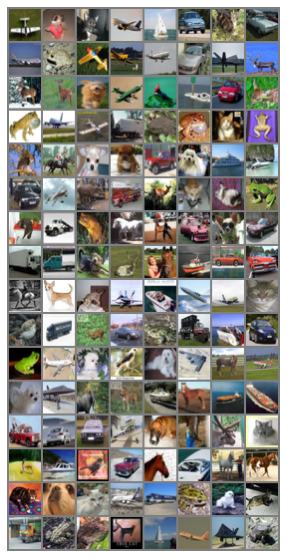

In [9]:
# Display images
images, labels = iter(train_loader).next()

# see: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
imshow(utils.make_grid(images))

# 3. RAY Tune

In the previous few notebooks, we manually tried different hyperparameters to get the best results. We will now explore Ray Tune and how it can help us speeding up the search for best hyperparameters.

We are going to define the following:

* Objective to maximise - which is test accuracy in our case
* Hyperparam search space
* Search algorithm to find best hyperparams


![](https://docs.ray.io/en/latest/_images/tune-workflow.png)

Source: https://docs.ray.io/en/latest/tune/key-concepts.html

# 4. Use Pretrained Models
Instead of training the full model, it is generally a good practice to use a pretrained network as a base model and add your layers on top. This allows us to reduce the training times and leverage on what base model has learned.

After you're done with this notebook, you will be able to use Ray Tune to design the network from scratch.

# 4.1. Define Model

We will use imagenet pre-trained ResNet50 model. You can swap out the base model with others such as ResNet 18 or ResNet 110. Just make sure the input features of the final layer matches with the out features of your base model.

In [10]:
class SimpleNet(nn.Module):
    """Simple Neural Network"""
    def __init__(self, base_model, base_fc_out, num_units, drop_rate, activation):
        """
        Parameters:
            base_model: Backbone/Pretrained Neural Network
            base_fc_out: Output unit of the base model
            num_units: Number of Input units of the hidden layer
            drop_rate: Dropout rate
            activation: Activation of hidden unit
        """
        super(SimpleNet, self).__init__()
        self.base_model = base_model
        # FC will be set as requires_grad=True by default
        self.base_model.fc = nn.Linear(base_fc_out, num_units)
        self.drop1 = nn.Dropout(p=drop_rate)
        self.fc1 = nn.Linear(num_units, 10)
        self.model = nn.Sequential(
            self.base_model,
            activation,
            self.fc1
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

## 4.2 Trainable

As with TensorFlow Ray-Tune notebook, we will make use of Trainable API. You can also use the [Functional API](https://docs.ray.io/en/latest/tune/examples/mnist_pytorch.html) to create the trainables.

We use the following functions from `tune.Trainable`:
- setup: invoked once when training begins
- step: called interatively
- cleanup: called when training ends

In [22]:
class PyTorchCIFAR10Trainable(tune.Trainable):
    """CIFAR10 Trainable"""    

    def setup(self, config):
        """Set the network for training
        
        Parameters
        ----------
        config: Ray config object that contains the hyperparams        
        """
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(self.device)
        # load data
        self.train_loader, self.test_loader = load_data(BATCH_SIZE, NUM_WORKERS)
        # create model        
        base_model = models.resnet50(pretrained=True)
        for param in base_model.parameters():
            param.requires_grad = False        
        # NN config
        num_units = config.get("hidden_units", 128)                    
        drop_rate = config.get("drop_rate", 0.0)        
        activation = config.get("activation", nn.ReLU(True))        
        self.model = SimpleNet(base_model, 2048, num_units, drop_rate, activation)
        self.model.to(self.device)
        # optimizer & loss
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(
            self.model.parameters(), 
            lr=config.get("learning_rate", 1e-4), 
            momentum=config.get("momentum", 0.9)
        )
        
        
    def _train_step(self):
        """Single training loop
        """
        # set to the model train mode
        self.model.train()
        epoch_loss = 0
        running_corrects = 0
        for images, labels  in self.train_loader:
            images = images.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                preds = self.model(images)
                loss = self.criterion(preds, labels)
                self.optimizer.step()
                # track losses
                epoch_loss += loss.item()
                _, predicted = torch.max(preds.data, 1)
                running_corrects += torch.sum(predicted == labels).item()
                
        loss = epoch_loss/len(self.train_loader)
        corrects = running_corrects/len(self.train_loader)
        return loss, corrects
    
    def _test_step(self):
        """Single test loop
        """        
        # set to model to eval mode
        self.model.eval()
        running_corrects = 0
        for images, labels  in self.train_loader:
            images = images.to(self.device)
            labels = labels.to(self.device)
            preds = self.model(images)
            loss = self.criterion(preds, labels)
            _, predicted = torch.max(preds.data, 1)
            running_corrects += torch.sum(predicted == labels).item()
                
        corrects = running_corrects/len(self.test_loader)
        return corrects
    
    def step(self):
        """Single training step
        """
        train_loss, train_acc = self._train_step()
        test_acc = self._test_step()
        return {
            "train_loss": train_loss, 
            "train_accuracy": train_acc,
            "mean_accuracy": test_acc
        }

    def save_checkpoint(self, dirname):
        """Saves the model
        
        Parameters
        ----------
            dirname: directory to save the model
        """
        checkpoint_path = os.path.join(dirname, "pytorch-resnet50-raytune.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return checkpoint_path

    def load_checkpoint(self, checkpoint_path):
        """Loads the model
        
        Parameters
        ----------
            checkpoint_path: load the model from this path
        """
        self.model.load_state_dict(torch.load(checkpoint_path))

## 4.3 Setup Config

We now setup the search space for Ray Tune to find an optimal model for us

In [12]:
config = {
    "hidden_units": tune.grid_search([32, 64, 128, 256]),
    "drop_rate": tune.uniform(0.0, 0.8),
    "activation": tune.choice([nn.ReLU(True), nn.ELU(True), nn.SELU(True)]),
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "momentum": tune.uniform(0.1, 0.9)
}

# Terminate less promising trials using early stopping
scheduler = ASHAScheduler(metric="mean_accuracy", mode="max")

# 5. Run Trials
We are now ready to run the trials. You can comment the first two lines. I am doing it in order to access the dashboard over the network. 

In [14]:
# shutdown currently running instance
ray.shutdown()
# initialize with the new param
ray.init(dashboard_host="0.0.0.0")

start = time()
# run trials
analysis = tune.run(
    PyTorchCIFAR10Trainable,
    config=config,
    num_samples=15, # runs 15 jobs with separate sample from the search space
    checkpoint_at_end=True,
    checkpoint_freq=3,    
    scheduler=scheduler,
    stop={"training_iteration": 50},
    resources_per_trial={"cpu": 2, "gpu": 1},
    ray_auto_init=False
)
stop = time()

2020-10-25 10:22:13,856	INFO services.py:1166 -- View the Ray dashboard at http://192.168.86.61:8265


0it [00:00, ?it/s]2) 
0it [00:00, ?it/s]6) 


(pid=14472) cuda:0
(pid=14472) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz
(pid=14476) cpu
(pid=14476) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 87%|████████▋ | 148594688/170498071 [00:38<00:04, 4693824.75it/s]
170500096it [00:38, 4449625.29it/s]                               
 88%|████████▊ | 150773760/170498071 [00:38<00:04, 4847273.04it/s]


(pid=14472) Extracting ./data/cifar-10-python.tar.gz to ./data


 94%|█████████▍| 160620544/170498071 [00:40<00:02, 4836954.99it/s]


(pid=14472) Files already downloaded and verified


100%|█████████▉| 170139648/170498071 [00:42<00:00, 4997099.47it/s]
170500096it [00:42, 3998757.19it/s]                               


(pid=14476) Extracting ./data/cifar-10-python.tar.gz to ./data


(pid=14472) 2020-10-25 10:22:59,225	INFO trainable.py:255 -- Trainable.setup took 43.540 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


(pid=14476) Files already downloaded and verified


(pid=14476) 2020-10-25 10:23:01,702	INFO trainable.py:255 -- Trainable.setup took 46.017 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00001:
  date: 2020-10-25_10-23-14
  done: true
  experiment_id: ac1bfde6cac24d93aebfdf6e2da5ce31
  experiment_tag: 1_activation=ReLU(inplace=True),drop_rate=0.29613,hidden_units=64,learning_rate=0.00011127,momentum=0.84265
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 64.9620253164557
  node_ip: 192.168.86.61
  pid: 14472
  time_since_restore: 15.299389123916626
  time_this_iter_s: 15.299389123916626
  time_total_s: 15.299389123916626
  timestamp: 1603592594
  timesteps_since_restore: 0
  train_accuracy: 14.610795454545455
  train_loss: 2.303268365561962
  training_iteration: 1
  trial_id: e5a1b_00001
  


2020-10-25 10:23:14,692	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}
0it [00:00, ?it/s]4) 


(pid=14474) cuda:0
(pid=14474) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 99%|█████████▉| 169369600/170498071 [00:29<00:00, 5852192.07it/s]
170500096it [00:29, 5800385.71it/s]                               


(pid=14474) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=14474) Files already downloaded and verified


(pid=14474) 2020-10-25 10:23:49,242	INFO trainable.py:255 -- Trainable.setup took 33.942 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00002:
  date: 2020-10-25_10-24-04
  done: true
  experiment_id: 3e374555dd1941b1a08ba08fdc0382b7
  experiment_tag: 2_activation=ReLU(inplace=True),drop_rate=0.34255,hidden_units=128,learning_rate=0.079426,momentum=0.8709
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 56.55696202531646
  node_ip: 192.168.86.61
  pid: 14474
  time_since_restore: 15.394063949584961
  time_this_iter_s: 15.394063949584961
  time_total_s: 15.394063949584961
  timestamp: 1603592644
  timesteps_since_restore: 0
  train_accuracy: 12.803977272727273
  train_loss: 2.3184037296609445
  training_iteration: 1
  trial_id: e5a1b_00002
  


2020-10-25 10:24:04,798	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}


(pid=14471) cuda:0
(pid=14471) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]1) 
 99%|█████████▉| 169508864/170498071 [00:43<00:00, 6759713.33it/s]
170500096it [00:43, 3891700.17it/s]                               


(pid=14471) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=14471) Files already downloaded and verified


(pid=14471) 2020-10-25 10:24:53,735	INFO trainable.py:255 -- Trainable.setup took 48.331 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00003:
  date: 2020-10-25_10-25-08
  done: true
  experiment_id: 7a2df26a53d241adb3d7588624114d88
  experiment_tag: 3_activation=SELU(inplace=True),drop_rate=0.68241,hidden_units=256,learning_rate=0.00076445,momentum=0.40808
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 62.835443037974684
  node_ip: 192.168.86.61
  pid: 14471
  time_since_restore: 15.197495460510254
  time_this_iter_s: 15.197495460510254
  time_total_s: 15.197495460510254
  timestamp: 1603592708
  timesteps_since_restore: 0
  train_accuracy: 13.798295454545455
  train_loss: 2.3423713852058756
  training_iteration: 1
  trial_id: e5a1b_00003
  


2020-10-25 10:25:09,111	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=14469) cuda:0
(pid=14469) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]9) 
 99%|█████████▉| 169418752/170498071 [00:32<00:00, 5158849.18it/s] 
170500096it [00:32, 5194874.88it/s]                               


(pid=14469) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=14469) Files already downloaded and verified


(pid=14469) 2020-10-25 10:25:46,998	INFO trainable.py:255 -- Trainable.setup took 37.322 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00004:
  date: 2020-10-25_10-26-02
  done: true
  experiment_id: 9f330c1c06024f4f999891ce975a7980
  experiment_tag: 4_activation=ReLU(inplace=True),drop_rate=0.68091,hidden_units=32,learning_rate=0.00089282,momentum=0.23559
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 58.734177215189874
  node_ip: 192.168.86.61
  pid: 14469
  time_since_restore: 15.128427505493164
  time_this_iter_s: 15.128427505493164
  time_total_s: 15.128427505493164
  timestamp: 1603592762
  timesteps_since_restore: 0
  train_accuracy: 13.082386363636363
  train_loss: 2.319947162135081
  training_iteration: 1
  trial_id: e5a1b_00004
  


2020-10-25 10:26:02,295	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}


(pid=14468) cuda:0
(pid=14468) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]8) 
 99%|█████████▉| 169533440/170498071 [00:33<00:00, 9277568.95it/s] 
170500096it [00:33, 5123592.09it/s]                               


(pid=14468) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=14468) Files already downloaded and verified


(pid=14468) 2020-10-25 10:26:40,704	INFO trainable.py:255 -- Trainable.setup took 37.824 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00005:
  date: 2020-10-25_10-26-56
  done: true
  experiment_id: fd2d0fd6f39248d28b105c0d5ebb5bcf
  experiment_tag: 5_activation=SELU(inplace=True),drop_rate=0.44544,hidden_units=64,learning_rate=0.064338,momentum=0.65682
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 51.936708860759495
  node_ip: 192.168.86.61
  pid: 14468
  time_since_restore: 15.418859243392944
  time_this_iter_s: 15.418859243392944
  time_total_s: 15.418859243392944
  timestamp: 1603592816
  timesteps_since_restore: 0
  train_accuracy: 12.011363636363637
  train_loss: 2.3522712507031183
  training_iteration: 1
  trial_id: e5a1b_00005
  


2020-10-25 10:26:56,286	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=14480) cuda:0
(pid=14480) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]0) 
100%|█████████▉| 169918464/170498071 [00:38<00:00, 5451556.71it/s]
170500096it [00:38, 4429440.41it/s]                               


(pid=14480) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=14480) Files already downloaded and verified


(pid=14480) 2020-10-25 10:27:39,923	INFO trainable.py:255 -- Trainable.setup took 43.052 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00006:
  date: 2020-10-25_10-27-55
  done: true
  experiment_id: 7d862626eb5240a890ec86f2a12f7395
  experiment_tag: 6_activation=SELU(inplace=True),drop_rate=0.45605,hidden_units=128,learning_rate=0.00019567,momentum=0.59201
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 62.68354430379747
  node_ip: 192.168.86.61
  pid: 14480
  time_since_restore: 15.3145911693573
  time_this_iter_s: 15.3145911693573
  time_total_s: 15.3145911693573
  timestamp: 1603592875
  timesteps_since_restore: 0
  train_accuracy: 13.934659090909092
  train_loss: 2.3309759104793724
  training_iteration: 1
  trial_id: e5a1b_00006
  


2020-10-25 10:27:55,406	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=14470) cuda:0
(pid=14470) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]0) 
100%|█████████▉| 169664512/170498071 [00:33<00:00, 6561127.01it/s]
170500096it [00:33, 5026577.25it/s]                               


(pid=14470) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=14470) Files already downloaded and verified


(pid=14470) 2020-10-25 10:28:34,464	INFO trainable.py:255 -- Trainable.setup took 38.484 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-28-49
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 67.51898734177215
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 15.369166612625122
  time_this_iter_s: 15.369166612625122
  time_total_s: 15.369166612625122
  timestamp: 1603592929
  timesteps_since_restore: 0
  train_accuracy: 15.315340909090908
  train_loss: 2.3130011944608255
  training_iteration: 1
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-29-05
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 2
  mean_accuracy: 67.22784810126582
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 30.54696750640869
  time_this_iter_s: 15.17780089378357
  time_total_s: 30.54696750640869
  timestamp: 1603592945
  timesteps_since_restore: 0
  train_accuracy: 14.778409090909092
  train_loss: 2.3139084415002302
  training_iteration: 2
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-29-20
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 3
  mean_accuracy: 66.9493670886076
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 45.79553246498108
  time_this_iter_s: 15.248564958572388
  time_total_s: 45.79553246498108
  timestamp: 1603592960
  timesteps_since_restore: 0
  train_accuracy: 14.838068181818182
  train_loss: 2.313623205504634
  training_iteration: 3
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-29-35
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 4
  mean_accuracy: 67.0253164556962
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 61.04997253417969
  time_this_iter_s: 15.254440069198608
  time_total_s: 61.04997253417969
  timestamp: 1603592975
  timesteps_since_restore: 0
  train_accuracy: 15.068181818181818
  train_loss: 2.31322764266621
  training_iteration: 4
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-29-50
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 5
  mean_accuracy: 66.87341772151899
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 76.28490781784058
  time_this_iter_s: 15.234935283660889
  time_total_s: 76.28490781784058
  timestamp: 1603592990
  timesteps_since_restore: 0
  train_accuracy: 15.178977272727273
  train_loss: 2.3134158091111616
  training_iteration: 5
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-30-06
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 6
  mean_accuracy: 67.13924050632912
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 91.52554655075073
  time_this_iter_s: 15.240638732910156
  time_total_s: 91.52554655075073
  timestamp: 1603593006
  timesteps_since_restore: 0
  train_accuracy: 15.196022727272727
  train_loss: 2.3136083355004136
  training_iteration: 6
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-30-21
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 7
  mean_accuracy: 67.60759493670886
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 106.75112700462341
  time_this_iter_s: 15.22558045387268
  time_total_s: 106.75112700462341
  timestamp: 1603593021
  timesteps_since_restore: 0
  train_accuracy: 15.164772727272727
  train_loss: 2.3132713159376923
  training_iteration: 7
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00000:
  date: 2020-10-25_10-30-31
  done: true
  experiment_id: e7c0c5f1e288451fa663952badef3474
  experiment_tag: 0_activation=ReLU(inplace=True),drop_rate=0.75237,hidden_units=32,learning_rate=0.072742,momentum=0.83189
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 61.25316455696203
  node_ip: 192.168.86.61
  pid: 14476
  time_since_restore: 449.46822690963745
  time_this_iter_s: 449.46822690963745
  time_total_s: 449.46822690963745
  timestamp: 1603593031
  timesteps_since_restore: 0
  train_accuracy: 13.769886363636363
  train_loss: 2.3410877829248253
  training_iteration: 1
  trial_id: e5a1b_00000
  


2020-10-25 10:30:31,274	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}
0it [00:00, ?it/s]7) 


(pid=14477) cpu
(pid=14477) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


  2%|▏         | 3792896/170498071 [00:04<02:13, 1244391.41it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-30-36
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 8
  mean_accuracy: 66.46835443037975
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 122.02254104614258
  time_this_iter_s: 15.271414041519165
  time_total_s: 122.02254104614258
  timestamp: 1603593036
  timesteps_since_restore: 0
  train_accuracy: 15.045454545454545
  train_loss: 2.3133237687024204
  training_iteration: 8
  trial_id: e5a1b_00007
  


  2%|▏         | 4136960/170498071 [00:04<02:01, 1366737.87it/s]


 54%|█████▍    | 92110848/170498071 [00:19<00:10, 7440561.06it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-30-51
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 9
  mean_accuracy: 67.84810126582279
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 137.01360845565796
  time_this_iter_s: 14.99106740951538
  time_total_s: 137.01360845565796
  timestamp: 1603593051
  timesteps_since_restore: 0
  train_accuracy: 14.965909090909092
  train_loss: 2.3134234554388304
  training_iteration: 9
  trial_id: e5a1b_00007
  


 55%|█████▍    | 93069312/170498071 [00:19<00:09, 7874335.88it/s]


100%|█████████▉| 169992192/170498071 [00:29<00:00, 6545964.04it/s]
170500096it [00:30, 5669202.18it/s]                               


(pid=14477) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=14477) Files already downloaded and verified


(pid=14477) 2020-10-25 10:31:05,187	INFO trainable.py:255 -- Trainable.setup took 33.301 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-31-07
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 10
  mean_accuracy: 67.56962025316456
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 152.09481954574585
  time_this_iter_s: 15.08121109008789
  time_total_s: 152.09481954574585
  timestamp: 1603593067
  timesteps_since_restore: 0
  train_accuracy: 15.017045454545455
  train_loss: 2.3132145499641243
  training_iteration: 10
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-31-22
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 11
  mean_accuracy: 67.41772151898734
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 167.36763167381287
  time_this_iter_s: 15.272812128067017
  time_total_s: 167.36763167381287
  timestamp: 1603593082
  timesteps_since_restore: 0
  train_accuracy: 15.215909090909092
  train_loss: 2.313178800046444
  training_iteration: 11
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-31-37
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 12
  mean_accuracy: 68.07594936708861
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 182.6762433052063
  time_this_iter_s: 15.308611631393433
  time_total_s: 182.6762433052063
  timestamp: 1603593097
  timesteps_since_restore: 0
  train_accuracy: 15.096590909090908
  train_loss: 2.314235373654149
  training_iteration: 12
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-31-53
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 13
  mean_accuracy: 67.17721518987342
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 197.966628074646
  time_this_iter_s: 15.290384769439697
  time_total_s: 197.966628074646
  timestamp: 1603593113
  timesteps_since_restore: 0
  train_accuracy: 14.974431818181818
  train_loss: 2.3140658898787065
  training_iteration: 13
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-32-08
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 14
  mean_accuracy: 67.12658227848101
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 213.26823782920837
  time_this_iter_s: 15.301609754562378
  time_total_s: 213.26823782920837
  timestamp: 1603593128
  timesteps_since_restore: 0
  train_accuracy: 15.008522727272727
  train_loss: 2.314019265499982
  training_iteration: 14
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-32-23
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 15
  mean_accuracy: 67.9367088607595
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 228.5724549293518
  time_this_iter_s: 15.304217100143433
  time_total_s: 228.5724549293518
  timestamp: 1603593143
  timesteps_since_restore: 0
  train_accuracy: 15.207386363636363
  train_loss: 2.313645559955727
  training_iteration: 15
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-32-39
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 16
  mean_accuracy: 66.9493670886076
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 243.883722782135
  time_this_iter_s: 15.311267852783203
  time_total_s: 243.883722782135
  timestamp: 1603593159
  timesteps_since_restore: 0
  train_accuracy: 15.042613636363637
  train_loss: 2.3140709196979348
  training_iteration: 16
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-32-54
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 17
  mean_accuracy: 68.15189873417721
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 259.18340134620667
  time_this_iter_s: 15.299678564071655
  time_total_s: 259.18340134620667
  timestamp: 1603593174
  timesteps_since_restore: 0
  train_accuracy: 15.019886363636363
  train_loss: 2.3141826580871236
  training_iteration: 17
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-33-09
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 18
  mean_accuracy: 66.83544303797468
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 274.52326250076294
  time_this_iter_s: 15.339861154556274
  time_total_s: 274.52326250076294
  timestamp: 1603593189
  timesteps_since_restore: 0
  train_accuracy: 15.295454545454545
  train_loss: 2.314132568511096
  training_iteration: 18
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-33-25
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 19
  mean_accuracy: 67.62025316455696
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 289.9005379676819
  time_this_iter_s: 15.377275466918945
  time_total_s: 289.9005379676819
  timestamp: 1603593205
  timesteps_since_restore: 0
  train_accuracy: 15.315340909090908
  train_loss: 2.314288057386875
  training_iteration: 19
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-33-40
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 20
  mean_accuracy: 66.84810126582279
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 305.18147706985474
  time_this_iter_s: 15.280939102172852
  time_total_s: 305.18147706985474
  timestamp: 1603593220
  timesteps_since_restore: 0
  train_accuracy: 15.34375
  train_loss: 2.3138568089766935
  training_iteration: 20
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-33-55
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 21
  mean_accuracy: 67.35443037974683
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 320.4068293571472
  time_this_iter_s: 15.22535228729248
  time_total_s: 320.4068293571472
  timestamp: 1603593235
  timesteps_since_restore: 0
  train_accuracy: 15.090909090909092
  train_loss: 2.314199538393454
  training_iteration: 21
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-34-11
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 22
  mean_accuracy: 66.9873417721519
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 335.77283787727356
  time_this_iter_s: 15.366008520126343
  time_total_s: 335.77283787727356
  timestamp: 1603593251
  timesteps_since_restore: 0
  train_accuracy: 14.863636363636363
  train_loss: 2.3145367076451127
  training_iteration: 22
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-34-26
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 23
  mean_accuracy: 67.78481012658227
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 351.12976241111755
  time_this_iter_s: 15.356924533843994
  time_total_s: 351.12976241111755
  timestamp: 1603593266
  timesteps_since_restore: 0
  train_accuracy: 15.0625
  train_loss: 2.3129126212813635
  training_iteration: 23
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-34-42
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 24
  mean_accuracy: 67.41772151898734
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 366.460791349411
  time_this_iter_s: 15.331028938293457
  time_total_s: 366.460791349411
  timestamp: 1603593282
  timesteps_since_restore: 0
  train_accuracy: 15.107954545454545
  train_loss: 2.313200368122621
  training_iteration: 24
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-34-57
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 25
  mean_accuracy: 67.18987341772151
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 381.71275568008423
  time_this_iter_s: 15.251964330673218
  time_total_s: 381.71275568008423
  timestamp: 1603593297
  timesteps_since_restore: 0
  train_accuracy: 14.928977272727273
  train_loss: 2.313616208732128
  training_iteration: 25
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-35-12
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 26
  mean_accuracy: 66.83544303797468
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 396.99172854423523
  time_this_iter_s: 15.278972864151001
  time_total_s: 396.99172854423523
  timestamp: 1603593312
  timesteps_since_restore: 0
  train_accuracy: 14.721590909090908
  train_loss: 2.3143216730518774
  training_iteration: 26
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-35-28
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 27
  mean_accuracy: 66.9113924050633
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 412.28532242774963
  time_this_iter_s: 15.293593883514404
  time_total_s: 412.28532242774963
  timestamp: 1603593328
  timesteps_since_restore: 0
  train_accuracy: 15.201704545454545
  train_loss: 2.3139414685693653
  training_iteration: 27
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-35-43
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 28
  mean_accuracy: 67.9493670886076
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 427.6444728374481
  time_this_iter_s: 15.359150409698486
  time_total_s: 427.6444728374481
  timestamp: 1603593343
  timesteps_since_restore: 0
  train_accuracy: 14.974431818181818
  train_loss: 2.3148262351751328
  training_iteration: 28
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-35-59
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 29
  mean_accuracy: 67.16455696202532
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 443.07418751716614
  time_this_iter_s: 15.429714679718018
  time_total_s: 443.07418751716614
  timestamp: 1603593359
  timesteps_since_restore: 0
  train_accuracy: 15.167613636363637
  train_loss: 2.3138717291030018
  training_iteration: 29
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-36-14
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 30
  mean_accuracy: 67.60759493670886
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 458.351598739624
  time_this_iter_s: 15.277411222457886
  time_total_s: 458.351598739624
  timestamp: 1603593374
  timesteps_since_restore: 0
  train_accuracy: 14.90625
  train_loss: 2.3137975998900155
  training_iteration: 30
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-36-29
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 31
  mean_accuracy: 66.70886075949367
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 473.7059943675995
  time_this_iter_s: 15.354395627975464
  time_total_s: 473.7059943675995
  timestamp: 1603593389
  timesteps_since_restore: 0
  train_accuracy: 15.144886363636363
  train_loss: 2.31350699338046
  training_iteration: 31
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-36-45
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 32
  mean_accuracy: 67.26582278481013
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 489.01561737060547
  time_this_iter_s: 15.309623003005981
  time_total_s: 489.01561737060547
  timestamp: 1603593405
  timesteps_since_restore: 0
  train_accuracy: 15.136363636363637
  train_loss: 2.313723498447375
  training_iteration: 32
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-37-00
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 33
  mean_accuracy: 67.21518987341773
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 504.4433002471924
  time_this_iter_s: 15.427682876586914
  time_total_s: 504.4433002471924
  timestamp: 1603593420
  timesteps_since_restore: 0
  train_accuracy: 15.241477272727273
  train_loss: 2.3141609958627005
  training_iteration: 33
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-37-16
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 34
  mean_accuracy: 66.89873417721519
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 519.7542536258698
  time_this_iter_s: 15.310953378677368
  time_total_s: 519.7542536258698
  timestamp: 1603593436
  timesteps_since_restore: 0
  train_accuracy: 15.198863636363637
  train_loss: 2.312824868343093
  training_iteration: 34
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-37-31
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 35
  mean_accuracy: 67.12658227848101
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 535.0282328128815
  time_this_iter_s: 15.273979187011719
  time_total_s: 535.0282328128815
  timestamp: 1603593451
  timesteps_since_restore: 0
  train_accuracy: 15.125
  train_loss: 2.3140529969876464
  training_iteration: 35
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-37-46
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 36
  mean_accuracy: 66.43037974683544
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 550.3408923149109
  time_this_iter_s: 15.312659502029419
  time_total_s: 550.3408923149109
  timestamp: 1603593466
  timesteps_since_restore: 0
  train_accuracy: 15.139204545454545
  train_loss: 2.313925429501317
  training_iteration: 36
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-38-02
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 37
  mean_accuracy: 66.60759493670886
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 565.6509900093079
  time_this_iter_s: 15.310097694396973
  time_total_s: 565.6509900093079
  timestamp: 1603593482
  timesteps_since_restore: 0
  train_accuracy: 15.392045454545455
  train_loss: 2.313574742864479
  training_iteration: 37
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-38-17
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 38
  mean_accuracy: 66.54430379746836
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 580.9884912967682
  time_this_iter_s: 15.337501287460327
  time_total_s: 580.9884912967682
  timestamp: 1603593497
  timesteps_since_restore: 0
  train_accuracy: 14.965909090909092
  train_loss: 2.3141091005368666
  training_iteration: 38
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-38-32
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 39
  mean_accuracy: 66.9493670886076
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 596.3374865055084
  time_this_iter_s: 15.348995208740234
  time_total_s: 596.3374865055084
  timestamp: 1603593512
  timesteps_since_restore: 0
  train_accuracy: 15.252840909090908
  train_loss: 2.313800624825738
  training_iteration: 39
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00008:
  date: 2020-10-25_10-38-43
  done: true
  experiment_id: 852004158b2f4ee1a851b11b8567541d
  experiment_tag: 8_activation=ELU(alpha=True),drop_rate=0.7019,hidden_units=32,learning_rate=0.016684,momentum=0.65761
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 58.36708860759494
  node_ip: 192.168.86.61
  pid: 14477
  time_since_restore: 458.59377360343933
  time_this_iter_s: 458.59377360343933
  time_total_s: 458.59377360343933
  timestamp: 1603593523
  timesteps_since_restore: 0
  train_accuracy: 13.153409090909092
  train_loss: 2.3343163566155867
  training_iteration: 1
  trial_id: e5a1b_00008
  


2020-10-25 10:38:43,893	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}
0it [00:00, ?it/s]3) 


(pid=14473) cpu
(pid=14473) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


  1%|          | 1335296/170498071 [00:03<05:39, 498856.26it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-38-48
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 40
  mean_accuracy: 67.60759493670886
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 611.5593600273132
  time_this_iter_s: 15.22187352180481
  time_total_s: 611.5593600273132
  timestamp: 1603593528
  timesteps_since_restore: 0
  train_accuracy: 15.329545454545455
  train_loss: 2.3134726502678613
  training_iteration: 40
  trial_id: e5a1b_00007
  


 35%|███▌      | 60268544/170498071 [00:18<00:15, 7311611.95it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-39-03
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 41
  mean_accuracy: 66.82278481012658
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 626.6218528747559
  time_this_iter_s: 15.062492847442627
  time_total_s: 626.6218528747559
  timestamp: 1603593543
  timesteps_since_restore: 0
  train_accuracy: 15.252840909090908
  train_loss: 2.3133508265018463
  training_iteration: 41
  trial_id: e5a1b_00007
  


 37%|███▋      | 62611456/170498071 [00:18<00:21, 5060040.09it/s]


 99%|█████████▉| 169418752/170498071 [00:33<00:00, 7819137.52it/s]
170500096it [00:33, 5069001.23it/s]                               


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-39-18
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 42
  mean_accuracy: 67.43037974683544
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 641.7041301727295
  time_this_iter_s: 15.082277297973633
  time_total_s: 641.7041301727295
  timestamp: 1603593558
  timesteps_since_restore: 0
  train_accuracy: 14.880681818181818
  train_loss: 2.313970850272612
  training_iteration: 42
  trial_id: e5a1b_00007
  
(pid=14473) Extracting ./data/cifar-10-python.tar.gz to ./data


(pid=14473) Files already downloaded and verified


(pid=14473) 2020-10-25 10:39:21,385	INFO trainable.py:255 -- Trainable.setup took 36.935 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-39-33
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 43
  mean_accuracy: 67.11392405063292
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 656.9879372119904
  time_this_iter_s: 15.283807039260864
  time_total_s: 656.9879372119904
  timestamp: 1603593573
  timesteps_since_restore: 0
  train_accuracy: 15.014204545454545
  train_loss: 2.3136963065374982
  training_iteration: 43
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-39-49
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 44
  mean_accuracy: 67.30379746835443
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 672.2752244472504
  time_this_iter_s: 15.28728723526001
  time_total_s: 672.2752244472504
  timestamp: 1603593589
  timesteps_since_restore: 0
  train_accuracy: 15.0625
  train_loss: 2.3140315907922657
  training_iteration: 44
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-40-04
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 45
  mean_accuracy: 66.55696202531645
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 687.5008211135864
  time_this_iter_s: 15.22559666633606
  time_total_s: 687.5008211135864
  timestamp: 1603593604
  timesteps_since_restore: 0
  train_accuracy: 14.991477272727273
  train_loss: 2.3140226114879954
  training_iteration: 45
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-40-19
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 46
  mean_accuracy: 67.59493670886076
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 702.7828109264374
  time_this_iter_s: 15.281989812850952
  time_total_s: 702.7828109264374
  timestamp: 1603593619
  timesteps_since_restore: 0
  train_accuracy: 15.153409090909092
  train_loss: 2.3137594623999163
  training_iteration: 46
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-40-35
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 47
  mean_accuracy: 67.63291139240506
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 718.0186862945557
  time_this_iter_s: 15.235875368118286
  time_total_s: 718.0186862945557
  timestamp: 1603593635
  timesteps_since_restore: 0
  train_accuracy: 15.025568181818182
  train_loss: 2.3138251704248516
  training_iteration: 47
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-40-50
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 48
  mean_accuracy: 68.39240506329114
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 733.3843989372253
  time_this_iter_s: 15.365712642669678
  time_total_s: 733.3843989372253
  timestamp: 1603593650
  timesteps_since_restore: 0
  train_accuracy: 14.982954545454545
  train_loss: 2.3133950064128097
  training_iteration: 48
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-41-06
  done: false
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 49
  mean_accuracy: 68.87341772151899
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 748.7407147884369
  time_this_iter_s: 15.356315851211548
  time_total_s: 748.7407147884369
  timestamp: 1603593666
  timesteps_since_restore: 0
  train_accuracy: 15.326704545454545
  train_loss: 2.313831564377655
  training_iteration: 49
  trial_id: e5a1b_00007
  


Result for PyTorchCIFAR10Trainable_e5a1b_00007:
  date: 2020-10-25_10-41-21
  done: true
  experiment_id: 0292f7c20f02475b80a79e4385c5fc81
  experiment_tag: 7_activation=ELU(alpha=True),drop_rate=0.79204,hidden_units=256,learning_rate=0.00026318,momentum=0.51466
  hostname: ironman
  iterations_since_restore: 50
  mean_accuracy: 67.37974683544304
  node_ip: 192.168.86.61
  pid: 14470
  time_since_restore: 764.090473651886
  time_this_iter_s: 15.349758863449097
  time_total_s: 764.090473651886
  timestamp: 1603593681
  timesteps_since_restore: 0
  train_accuracy: 15.099431818181818
  train_loss: 2.31364706158638
  training_iteration: 50
  trial_id: e5a1b_00007
  


2020-10-25 10:41:21,565	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}
0it [00:00, ?it/s]8) 


(pid=14478) cuda:0
(pid=14478) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100%|█████████▉| 170106880/170498071 [00:34<00:00, 4853842.67it/s]
170500096it [00:34, 4984471.40it/s]                               


(pid=14478) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=14478) Files already downloaded and verified


(pid=14478) 2020-10-25 10:42:00,872	INFO trainable.py:255 -- Trainable.setup took 38.724 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00010:
  date: 2020-10-25_10-42-16
  done: true
  experiment_id: e384f637820a40cf892edf66ce7cf640
  experiment_tag: 10_activation=SELU(inplace=True),drop_rate=0.64749,hidden_units=128,learning_rate=0.026936,momentum=0.79366
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 57.721518987341774
  node_ip: 192.168.86.61
  pid: 14478
  time_since_restore: 15.366005420684814
  time_this_iter_s: 15.366005420684814
  time_total_s: 15.366005420684814
  timestamp: 1603593736
  timesteps_since_restore: 0
  train_accuracy: 12.880681818181818
  train_loss: 2.326554910703139
  training_iteration: 1
  trial_id: e5a1b_00010
  


2020-10-25 10:42:16,411	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=14467) cuda:0
(pid=14467) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]7) 
100%|█████████▉| 170074112/170498071 [00:26<00:00, 8373563.96it/s]
170500096it [00:26, 6453301.69it/s]                               


(pid=14467) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=14467) Files already downloaded and verified


(pid=14467) 2020-10-25 10:42:47,887	INFO trainable.py:255 -- Trainable.setup took 30.883 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00011:
  date: 2020-10-25_10-43-03
  done: true
  experiment_id: 8636d3e808d74a82ad863c8882cd3cd9
  experiment_tag: 11_activation=SELU(inplace=True),drop_rate=0.73059,hidden_units=256,learning_rate=0.00342,momentum=0.50121
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 56.11392405063291
  node_ip: 192.168.86.61
  pid: 14467
  time_since_restore: 15.263139009475708
  time_this_iter_s: 15.263139009475708
  time_total_s: 15.263139009475708
  timestamp: 1603593783
  timesteps_since_restore: 0
  train_accuracy: 12.539772727272727
  train_loss: 2.3437967896461487
  training_iteration: 1
  trial_id: e5a1b_00011
  


2020-10-25 10:43:03,320	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}
0it [00:00, ?it/s]5) 


(pid=22135) cuda:0
(pid=22135) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100%|█████████▉| 170213376/170498071 [00:26<00:00, 4214841.45it/s]
170500096it [00:26, 6429744.20it/s]                               


(pid=22135) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=22135) Files already downloaded and verified


(pid=22135) 2020-10-25 10:43:35,229	INFO trainable.py:255 -- Trainable.setup took 31.038 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00012:
  date: 2020-10-25_10-43-50
  done: true
  experiment_id: cf6cc3258a5e4bb3ad6cd841865a8802
  experiment_tag: 12_activation=ReLU(inplace=True),drop_rate=0.63864,hidden_units=32,learning_rate=0.0089103,momentum=0.66157
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 56.58227848101266
  node_ip: 192.168.86.61
  pid: 22135
  time_since_restore: 15.35981273651123
  time_this_iter_s: 15.35981273651123
  time_total_s: 15.35981273651123
  timestamp: 1603593830
  timesteps_since_restore: 0
  train_accuracy: 12.707386363636363
  train_loss: 2.331516767090017
  training_iteration: 1
  trial_id: e5a1b_00012
  


2020-10-25 10:43:50,753	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}
0it [00:00, ?it/s]3) 


(pid=22363) cuda:0
(pid=22363) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 99%|█████████▉| 169508864/170498071 [00:34<00:00, 7246469.56it/s]
170500096it [00:34, 4979646.19it/s]                               


(pid=22363) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=22363) Files already downloaded and verified


(pid=22363) 2020-10-25 10:44:30,395	INFO trainable.py:255 -- Trainable.setup took 38.761 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00013:
  date: 2020-10-25_10-44-45
  done: true
  experiment_id: 1c71743802d94d20bdec5d91a75aff56
  experiment_tag: 13_activation=SELU(inplace=True),drop_rate=0.63663,hidden_units=64,learning_rate=0.046775,momentum=0.3704
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 52.53164556962025
  node_ip: 192.168.86.61
  pid: 22363
  time_since_restore: 15.342734575271606
  time_this_iter_s: 15.342734575271606
  time_total_s: 15.342734575271606
  timestamp: 1603593885
  timesteps_since_restore: 0
  train_accuracy: 11.903409090909092
  train_loss: 2.3453086573969233
  training_iteration: 1
  trial_id: e5a1b_00013
  


2020-10-25 10:44:45,900	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=22553) cuda:0
(pid=22553) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]3) 
 99%|█████████▉| 169287680/170498071 [00:27<00:00, 8768588.80it/s]
170500096it [00:27, 6185540.67it/s]                               


(pid=22553) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=22553) Files already downloaded and verified


(pid=22553) 2020-10-25 10:45:18,823	INFO trainable.py:255 -- Trainable.setup took 32.052 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00014:
  date: 2020-10-25_10-45-34
  done: true
  experiment_id: eb8a26188f3c45b1afff9820c1bf0c62
  experiment_tag: 14_activation=ReLU(inplace=True),drop_rate=0.30047,hidden_units=128,learning_rate=0.0001914,momentum=0.56262
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 53.11392405063291
  node_ip: 192.168.86.61
  pid: 22553
  time_since_restore: 15.277311086654663
  time_this_iter_s: 15.277311086654663
  time_total_s: 15.277311086654663
  timestamp: 1603593934
  timesteps_since_restore: 0
  train_accuracy: 11.448863636363637
  train_loss: 2.3165191012349995
  training_iteration: 1
  trial_id: e5a1b_00014
  


2020-10-25 10:45:34,272	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}


(pid=22736) cuda:0
(pid=22736) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]6) 
 99%|█████████▉| 169041920/170498071 [00:25<00:00, 8512786.80it/s]
170500096it [00:25, 6688077.44it/s]                               


(pid=22736) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=22736) Files already downloaded and verified


(pid=22736) 2020-10-25 10:46:05,157	INFO trainable.py:255 -- Trainable.setup took 30.032 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00015:
  date: 2020-10-25_10-46-20
  done: true
  experiment_id: ff43b56a4138404cb4a16ff008cc42d4
  experiment_tag: 15_activation=SELU(inplace=True),drop_rate=0.028754,hidden_units=256,learning_rate=0.0024934,momentum=0.53412
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 55.51898734177215
  node_ip: 192.168.86.61
  pid: 22736
  time_since_restore: 15.206795692443848
  time_this_iter_s: 15.206795692443848
  time_total_s: 15.206795692443848
  timestamp: 1603593980
  timesteps_since_restore: 0
  train_accuracy: 12.340909090909092
  train_loss: 2.362239279530265
  training_iteration: 1
  trial_id: e5a1b_00015
  


2020-10-25 10:46:20,530	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=22914) cuda:0
(pid=22914) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]4) 
 99%|█████████▉| 169549824/170498071 [00:24<00:00, 12020543.36it/s]
170500096it [00:24, 6989622.24it/s]                                


(pid=22914) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=22914) Files already downloaded and verified


(pid=22914) 2020-10-25 10:46:50,232	INFO trainable.py:255 -- Trainable.setup took 28.856 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00009:
  date: 2020-10-25_10-46-53
  done: true
  experiment_id: 4f1738f2e11a4d758c90e986d172a936
  experiment_tag: 9_activation=ReLU(inplace=True),drop_rate=0.56199,hidden_units=64,learning_rate=0.001198,momentum=0.33487
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 58.35443037974684
  node_ip: 192.168.86.61
  pid: 14473
  time_since_restore: 451.76224517822266
  time_this_iter_s: 451.76224517822266
  time_total_s: 451.76224517822266
  timestamp: 1603594013
  timesteps_since_restore: 0
  train_accuracy: 13.071022727272727
  train_loss: 2.3146613748236136
  training_iteration: 1
  trial_id: e5a1b_00009
  


2020-10-25 10:46:53,259	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}


(pid=23029) cpu
(pid=23029) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]9) 
 35%|███▍      | 59564032/170498071 [00:11<00:17, 6463142.26it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00016:
  date: 2020-10-25_10-47-05
  done: true
  experiment_id: 4112ab48cb4d4f3e9b4add8cff386956
  experiment_tag: 16_activation=ReLU(inplace=True),drop_rate=0.22923,hidden_units=32,learning_rate=0.0059224,momentum=0.1244
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 56.848101265822784
  node_ip: 192.168.86.61
  pid: 22914
  time_since_restore: 15.293168544769287
  time_this_iter_s: 15.293168544769287
  time_total_s: 15.293168544769287
  timestamp: 1603594025
  timesteps_since_restore: 0
  train_accuracy: 12.894886363636363
  train_loss: 2.324842843142423
  training_iteration: 1
  trial_id: e5a1b_00016
  


 36%|███▌      | 61349888/170498071 [00:11<00:15, 6862952.28it/s]


 36%|███▋      | 62152704/170498071 [00:11<00:15, 6838879.93it/s]
2020-10-25 10:47:05,683	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}
 41%|████      | 70049792/170498071 [00:12<00:13, 7394088.66it/s]
0it [00:00, ?it/s]4) 
 42%|████▏     | 70803456/170498071 [00:12<00:14, 7115028.81it/s]


(pid=23114) cuda:0
(pid=23114) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 52%|█████▏    | 87924736/170498071 [00:18<00:13, 5916687.00it/s]
170500096it [00:30, 5512584.24it/s]                               
 52%|█████▏    | 89399296/170498071 [00:18<00:13, 6110856.87it/s]


(pid=23029) Extracting ./data/cifar-10-python.tar.gz to ./data


 60%|█████▉    | 101916672/170498071 [00:20<00:11, 6213426.73it/s]


(pid=23029) Files already downloaded and verified


 62%|██████▏   | 106012672/170498071 [00:21<00:10, 6187406.68it/s]
(pid=23029) 2020-10-25 10:47:28,216	INFO trainable.py:255 -- Trainable.setup took 34.099 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 99%|█████████▉| 169435136/170498071 [00:30<00:00, 9007402.99it/s]
170500096it [00:30, 5604878.42it/s]                               


(pid=23114) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=23114) Files already downloaded and verified


(pid=23114) 2020-10-25 10:47:41,591	INFO trainable.py:255 -- Trainable.setup took 34.972 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00018:
  date: 2020-10-25_10-47-56
  done: true
  experiment_id: 00a8de99951e40129a2594c22458f96c
  experiment_tag: 18_activation=ELU(alpha=True),drop_rate=0.10165,hidden_units=128,learning_rate=0.0036875,momentum=0.71599
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 56.74683544303797
  node_ip: 192.168.86.61
  pid: 23114
  time_since_restore: 15.380659818649292
  time_this_iter_s: 15.380659818649292
  time_total_s: 15.380659818649292
  timestamp: 1603594076
  timesteps_since_restore: 0
  train_accuracy: 12.951704545454545
  train_loss: 2.3295809640125795
  training_iteration: 1
  trial_id: e5a1b_00018
  


2020-10-25 10:47:57,158	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}


(pid=23347) cuda:0
(pid=23347) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]7) 
 99%|█████████▉| 169500672/170498071 [00:41<00:00, 5640616.15it/s]
170500096it [00:41, 4115237.66it/s]                               


(pid=23523) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=23523) Files already downloaded and verified


(pid=23523) 2020-10-25 10:49:30,615	INFO trainable.py:255 -- Trainable.setup took 45.984 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00020:
  date: 2020-10-25_10-49-45
  done: true
  experiment_id: 4f41fc56524f4b20aa1a3ead71aaf6a8
  experiment_tag: 20_activation=ReLU(inplace=True),drop_rate=0.041345,hidden_units=32,learning_rate=0.003927,momentum=0.53251
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 54.58227848101266
  node_ip: 192.168.86.61
  pid: 23523
  time_since_restore: 15.305274724960327
  time_this_iter_s: 15.305274724960327
  time_total_s: 15.305274724960327
  timestamp: 1603594185
  timesteps_since_restore: 0
  train_accuracy: 12.625
  train_loss: 2.34310289404609
  training_iteration: 1
  trial_id: e5a1b_00020
  


2020-10-25 10:49:46,083	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}
0it [00:00, ?it/s]7) 


(pid=23717) cuda:0
(pid=23717) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100%|█████████▉| 169779200/170498071 [00:35<00:00, 7290982.31it/s]
170500096it [00:35, 4769139.91it/s]                               


(pid=23717) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=23717) Files already downloaded and verified


(pid=23717) 2020-10-25 10:50:27,194	INFO trainable.py:255 -- Trainable.setup took 40.270 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00021:
  date: 2020-10-25_10-50-42
  done: true
  experiment_id: 0f20a0985b494a98a267233cd2c277d8
  experiment_tag: 21_activation=SELU(inplace=True),drop_rate=0.50994,hidden_units=64,learning_rate=0.015076,momentum=0.88068
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 55.69620253164557
  node_ip: 192.168.86.61
  pid: 23717
  time_since_restore: 15.290067911148071
  time_this_iter_s: 15.290067911148071
  time_total_s: 15.290067911148071
  timestamp: 1603594242
  timesteps_since_restore: 0
  train_accuracy: 12.303977272727273
  train_loss: 2.342213223603639
  training_iteration: 1
  trial_id: e5a1b_00021
  


2020-10-25 10:50:42,651	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=23916) cuda:0
(pid=23916) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]6) 
100%|█████████▉| 169680896/170498071 [00:31<00:00, 8237308.95it/s]
170500096it [00:31, 5344849.27it/s]                               


(pid=23916) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=23916) Files already downloaded and verified


(pid=23916) 2020-10-25 10:51:19,914	INFO trainable.py:255 -- Trainable.setup took 36.422 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00022:
  date: 2020-10-25_10-51-35
  done: true
  experiment_id: 4d4431bad5d74ea090bd42391f04304a
  experiment_tag: 22_activation=ReLU(inplace=True),drop_rate=0.41304,hidden_units=128,learning_rate=0.00093083,momentum=0.73615
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 56.20253164556962
  node_ip: 192.168.86.61
  pid: 23916
  time_since_restore: 15.260676860809326
  time_this_iter_s: 15.260676860809326
  time_total_s: 15.260676860809326
  timestamp: 1603594295
  timesteps_since_restore: 0
  train_accuracy: 12.596590909090908
  train_loss: 2.3132240169427614
  training_iteration: 1
  trial_id: e5a1b_00022
  


2020-10-25 10:51:35,341	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}


(pid=24101) cuda:0
(pid=24101) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]1) 
100%|█████████▉| 169910272/170498071 [00:26<00:00, 7248615.06it/s]
170500096it [00:26, 6315180.12it/s]                               


(pid=24101) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=24101) Files already downloaded and verified


(pid=24101) 2020-10-25 10:52:07,735	INFO trainable.py:255 -- Trainable.setup took 31.503 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-52-23
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 66.89873417721519
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 15.282578229904175
  time_this_iter_s: 15.282578229904175
  time_total_s: 15.282578229904175
  timestamp: 1603594343
  timesteps_since_restore: 0
  train_accuracy: 15.139204545454545
  train_loss: 2.3132558275352824
  training_iteration: 1
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-52-38
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 2
  mean_accuracy: 67.81012658227849
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 30.5079402923584
  time_this_iter_s: 15.225362062454224
  time_total_s: 30.5079402923584
  timestamp: 1603594358
  timesteps_since_restore: 0
  train_accuracy: 15.153409090909092
  train_loss: 2.3136926124041732
  training_iteration: 2
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-52-53
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 3
  mean_accuracy: 67.48101265822785
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 45.74336004257202
  time_this_iter_s: 15.235419750213623
  time_total_s: 45.74336004257202
  timestamp: 1603594373
  timesteps_since_restore: 0
  train_accuracy: 15.383522727272727
  train_loss: 2.3128427057103678
  training_iteration: 3
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-53-08
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 4
  mean_accuracy: 67.37974683544304
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 60.937007188797
  time_this_iter_s: 15.193647146224976
  time_total_s: 60.937007188797
  timestamp: 1603594388
  timesteps_since_restore: 0
  train_accuracy: 15.201704545454545
  train_loss: 2.3129563189365645
  training_iteration: 4
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-53-24
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 5
  mean_accuracy: 68.51898734177215
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 76.1317412853241
  time_this_iter_s: 15.1947340965271
  time_total_s: 76.1317412853241
  timestamp: 1603594404
  timesteps_since_restore: 0
  train_accuracy: 15.147727272727273
  train_loss: 2.3135988895188677
  training_iteration: 5
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-53-39
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 6
  mean_accuracy: 67.40506329113924
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 91.3788492679596
  time_this_iter_s: 15.247107982635498
  time_total_s: 91.3788492679596
  timestamp: 1603594419
  timesteps_since_restore: 0
  train_accuracy: 14.946022727272727
  train_loss: 2.3135218999602576
  training_iteration: 6
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-53-54
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 7
  mean_accuracy: 67.25316455696202
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 106.6475477218628
  time_this_iter_s: 15.268698453903198
  time_total_s: 106.6475477218628
  timestamp: 1603594434
  timesteps_since_restore: 0
  train_accuracy: 15.213068181818182
  train_loss: 2.3132244009863245
  training_iteration: 7
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-54-09
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 8
  mean_accuracy: 67.70886075949367
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 121.89685368537903
  time_this_iter_s: 15.249305963516235
  time_total_s: 121.89685368537903
  timestamp: 1603594449
  timesteps_since_restore: 0
  train_accuracy: 15.252840909090908
  train_loss: 2.3134750297123734
  training_iteration: 8
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-54-25
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 9
  mean_accuracy: 68.41772151898734
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 137.27477025985718
  time_this_iter_s: 15.37791657447815
  time_total_s: 137.27477025985718
  timestamp: 1603594465
  timesteps_since_restore: 0
  train_accuracy: 15.386363636363637
  train_loss: 2.3137014962055464
  training_iteration: 9
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-54-40
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 10
  mean_accuracy: 68.26582278481013
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 152.59181809425354
  time_this_iter_s: 15.317047834396362
  time_total_s: 152.59181809425354
  timestamp: 1603594480
  timesteps_since_restore: 0
  train_accuracy: 15.323863636363637
  train_loss: 2.312798674133691
  training_iteration: 10
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-54-56
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 11
  mean_accuracy: 68.0506329113924
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 167.75966930389404
  time_this_iter_s: 15.167851209640503
  time_total_s: 167.75966930389404
  timestamp: 1603594496
  timesteps_since_restore: 0
  train_accuracy: 15.142045454545455
  train_loss: 2.3127939342097803
  training_iteration: 11
  trial_id: e5a1b_00023
  


2020-10-25 10:55:00,421	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}


Result for PyTorchCIFAR10Trainable_e5a1b_00017:
  date: 2020-10-25_10-55-00
  done: true
  experiment_id: bc70567a853b4a55ba58333f9110c4be
  experiment_tag: 17_activation=ELU(alpha=True),drop_rate=0.029879,hidden_units=64,learning_rate=0.029363,momentum=0.38815
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 57.164556962025316
  node_ip: 192.168.86.61
  pid: 23029
  time_since_restore: 452.0925886631012
  time_this_iter_s: 452.0925886631012
  time_total_s: 452.0925886631012
  timestamp: 1603594500
  timesteps_since_restore: 0
  train_accuracy: 12.815340909090908
  train_loss: 2.3263147784905
  training_iteration: 1
  trial_id: e5a1b_00017
  


0it [00:00, ?it/s]2) 


(pid=25522) cpu
(pid=25522) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 39%|███▊      | 65757184/170498071 [00:09<00:10, 10276256.04it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-55-11
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 12
  mean_accuracy: 68.15189873417721
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 182.9172899723053
  time_this_iter_s: 15.157620668411255
  time_total_s: 182.9172899723053
  timestamp: 1603594511
  timesteps_since_restore: 0
  train_accuracy: 15.042613636363637
  train_loss: 2.313210465691306
  training_iteration: 12
  trial_id: e5a1b_00023
  


 39%|███▉      | 66789376/170498071 [00:09<00:10, 9577514.32it/s] 


100%|█████████▉| 169959424/170498071 [00:20<00:00, 10529449.75it/s]
170500096it [00:20, 8500518.33it/s]                                


(pid=25522) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=25522) Files already downloaded and verified


(pid=25522) 2020-10-25 10:55:24,541	INFO trainable.py:255 -- Trainable.setup took 23.276 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-55-26
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 13
  mean_accuracy: 67.79746835443038
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 198.01703572273254
  time_this_iter_s: 15.099745750427246
  time_total_s: 198.01703572273254
  timestamp: 1603594526
  timesteps_since_restore: 0
  train_accuracy: 15.170454545454545
  train_loss: 2.3132674118334595
  training_iteration: 13
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-55-41
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 14
  mean_accuracy: 67.25316455696202
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 213.32692098617554
  time_this_iter_s: 15.309885263442993
  time_total_s: 213.32692098617554
  timestamp: 1603594541
  timesteps_since_restore: 0
  train_accuracy: 14.977272727272727
  train_loss: 2.3137322759086434
  training_iteration: 14
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-55-56
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 15
  mean_accuracy: 67.74683544303798
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 228.53451251983643
  time_this_iter_s: 15.207591533660889
  time_total_s: 228.53451251983643
  timestamp: 1603594556
  timesteps_since_restore: 0
  train_accuracy: 15.196022727272727
  train_loss: 2.3132733526554974
  training_iteration: 15
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-56-12
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 16
  mean_accuracy: 68.30379746835443
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 243.82693696022034
  time_this_iter_s: 15.292424440383911
  time_total_s: 243.82693696022034
  timestamp: 1603594572
  timesteps_since_restore: 0
  train_accuracy: 15.545454545454545
  train_loss: 2.313650876960971
  training_iteration: 16
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-56-27
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 17
  mean_accuracy: 68.50632911392405
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 259.0681838989258
  time_this_iter_s: 15.241246938705444
  time_total_s: 259.0681838989258
  timestamp: 1603594587
  timesteps_since_restore: 0
  train_accuracy: 15.144886363636363
  train_loss: 2.313972217115489
  training_iteration: 17
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-56-43
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 18
  mean_accuracy: 67.69620253164557
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 274.4091281890869
  time_this_iter_s: 15.340944290161133
  time_total_s: 274.4091281890869
  timestamp: 1603594603
  timesteps_since_restore: 0
  train_accuracy: 15.096590909090908
  train_loss: 2.3136918531222777
  training_iteration: 18
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-56-58
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 19
  mean_accuracy: 68.62025316455696
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 289.5901982784271
  time_this_iter_s: 15.18107008934021
  time_total_s: 289.5901982784271
  timestamp: 1603594618
  timesteps_since_restore: 0
  train_accuracy: 15.377840909090908
  train_loss: 2.31315995210951
  training_iteration: 19
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-57-13
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 20
  mean_accuracy: 68.9746835443038
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 304.8860363960266
  time_this_iter_s: 15.295838117599487
  time_total_s: 304.8860363960266
  timestamp: 1603594633
  timesteps_since_restore: 0
  train_accuracy: 15.255681818181818
  train_loss: 2.3129124370488254
  training_iteration: 20
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-57-28
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 21
  mean_accuracy: 67.9873417721519
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 320.0944390296936
  time_this_iter_s: 15.208402633666992
  time_total_s: 320.0944390296936
  timestamp: 1603594648
  timesteps_since_restore: 0
  train_accuracy: 15.034090909090908
  train_loss: 2.313699021935463
  training_iteration: 21
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-57-44
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 22
  mean_accuracy: 68.87341772151899
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 335.3825697898865
  time_this_iter_s: 15.288130760192871
  time_total_s: 335.3825697898865
  timestamp: 1603594664
  timesteps_since_restore: 0
  train_accuracy: 15.275568181818182
  train_loss: 2.312699069353667
  training_iteration: 22
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-57-59
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 23
  mean_accuracy: 67.82278481012658
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 350.6575222015381
  time_this_iter_s: 15.274952411651611
  time_total_s: 350.6575222015381
  timestamp: 1603594679
  timesteps_since_restore: 0
  train_accuracy: 14.997159090909092
  train_loss: 2.313123720613393
  training_iteration: 23
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-58-14
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 24
  mean_accuracy: 66.9367088607595
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 365.95018315315247
  time_this_iter_s: 15.29266095161438
  time_total_s: 365.95018315315247
  timestamp: 1603594694
  timesteps_since_restore: 0
  train_accuracy: 15.329545454545455
  train_loss: 2.3137358230623333
  training_iteration: 24
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-58-30
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 25
  mean_accuracy: 68.34177215189874
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 381.18161511421204
  time_this_iter_s: 15.23143196105957
  time_total_s: 381.18161511421204
  timestamp: 1603594710
  timesteps_since_restore: 0
  train_accuracy: 14.863636363636363
  train_loss: 2.3144176588817076
  training_iteration: 25
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-58-45
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 26
  mean_accuracy: 67.9873417721519
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 396.4829852581024
  time_this_iter_s: 15.30137014389038
  time_total_s: 396.4829852581024
  timestamp: 1603594725
  timesteps_since_restore: 0
  train_accuracy: 15.21875
  train_loss: 2.312857945534316
  training_iteration: 26
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-59-00
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 27
  mean_accuracy: 67.55696202531645
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 411.7385709285736
  time_this_iter_s: 15.255585670471191
  time_total_s: 411.7385709285736
  timestamp: 1603594740
  timesteps_since_restore: 0
  train_accuracy: 15.360795454545455
  train_loss: 2.312673983926123
  training_iteration: 27
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-59-16
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 28
  mean_accuracy: 66.9367088607595
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 426.9771647453308
  time_this_iter_s: 15.238593816757202
  time_total_s: 426.9771647453308
  timestamp: 1603594756
  timesteps_since_restore: 0
  train_accuracy: 15.125
  train_loss: 2.314179627732797
  training_iteration: 28
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-59-31
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 29
  mean_accuracy: 68.21518987341773
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 442.3133509159088
  time_this_iter_s: 15.336186170578003
  time_total_s: 442.3133509159088
  timestamp: 1603594771
  timesteps_since_restore: 0
  train_accuracy: 15.556818181818182
  train_loss: 2.312748197127472
  training_iteration: 29
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_10-59-46
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 30
  mean_accuracy: 68.34177215189874
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 457.5120451450348
  time_this_iter_s: 15.198694229125977
  time_total_s: 457.5120451450348
  timestamp: 1603594786
  timesteps_since_restore: 0
  train_accuracy: 15.321022727272727
  train_loss: 2.3130059933120553
  training_iteration: 30
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-00-02
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 31
  mean_accuracy: 68.35443037974683
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 472.7358250617981
  time_this_iter_s: 15.223779916763306
  time_total_s: 472.7358250617981
  timestamp: 1603594802
  timesteps_since_restore: 0
  train_accuracy: 15.323863636363637
  train_loss: 2.3128031349994917
  training_iteration: 31
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-00-17
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 32
  mean_accuracy: 68.56962025316456
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 488.0167467594147
  time_this_iter_s: 15.280921697616577
  time_total_s: 488.0167467594147
  timestamp: 1603594817
  timesteps_since_restore: 0
  train_accuracy: 15.235795454545455
  train_loss: 2.312500224194743
  training_iteration: 32
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-00-32
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 33
  mean_accuracy: 68.51898734177215
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 503.25849413871765
  time_this_iter_s: 15.241747379302979
  time_total_s: 503.25849413871765
  timestamp: 1603594832
  timesteps_since_restore: 0
  train_accuracy: 15.051136363636363
  train_loss: 2.3135474656115878
  training_iteration: 33
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-00-48
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 34
  mean_accuracy: 68.25316455696202
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 518.5486698150635
  time_this_iter_s: 15.290175676345825
  time_total_s: 518.5486698150635
  timestamp: 1603594848
  timesteps_since_restore: 0
  train_accuracy: 15.213068181818182
  train_loss: 2.312729985876517
  training_iteration: 34
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-01-03
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 35
  mean_accuracy: 67.64556962025317
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 533.7697687149048
  time_this_iter_s: 15.221098899841309
  time_total_s: 533.7697687149048
  timestamp: 1603594863
  timesteps_since_restore: 0
  train_accuracy: 15.525568181818182
  train_loss: 2.312719862569462
  training_iteration: 35
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-01-18
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 36
  mean_accuracy: 68.59493670886076
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 549.0623691082001
  time_this_iter_s: 15.292600393295288
  time_total_s: 549.0623691082001
  timestamp: 1603594878
  timesteps_since_restore: 0
  train_accuracy: 15.244318181818182
  train_loss: 2.313355115326968
  training_iteration: 36
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-01-34
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 37
  mean_accuracy: 68.30379746835443
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 564.2835803031921
  time_this_iter_s: 15.221211194992065
  time_total_s: 564.2835803031921
  timestamp: 1603594894
  timesteps_since_restore: 0
  train_accuracy: 15.193181818181818
  train_loss: 2.313546090640805
  training_iteration: 37
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-01-49
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 38
  mean_accuracy: 67.86075949367088
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 579.5890865325928
  time_this_iter_s: 15.305506229400635
  time_total_s: 579.5890865325928
  timestamp: 1603594909
  timesteps_since_restore: 0
  train_accuracy: 15.079545454545455
  train_loss: 2.3132692900570957
  training_iteration: 38
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-02-04
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 39
  mean_accuracy: 68.48101265822785
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 594.8700513839722
  time_this_iter_s: 15.280964851379395
  time_total_s: 594.8700513839722
  timestamp: 1603594924
  timesteps_since_restore: 0
  train_accuracy: 15.125
  train_loss: 2.3137931884689764
  training_iteration: 39
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-02-20
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 40
  mean_accuracy: 67.73417721518987
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 610.1479284763336
  time_this_iter_s: 15.27787709236145
  time_total_s: 610.1479284763336
  timestamp: 1603594940
  timesteps_since_restore: 0
  train_accuracy: 15.244318181818182
  train_loss: 2.313844871791926
  training_iteration: 40
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-02-35
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 41
  mean_accuracy: 68.46835443037975
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 625.4203469753265
  time_this_iter_s: 15.27241849899292
  time_total_s: 625.4203469753265
  timestamp: 1603594955
  timesteps_since_restore: 0
  train_accuracy: 15.017045454545455
  train_loss: 2.3128070418130267
  training_iteration: 41
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-02-50
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 42
  mean_accuracy: 68.65822784810126
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 640.7628116607666
  time_this_iter_s: 15.342464685440063
  time_total_s: 640.7628116607666
  timestamp: 1603594970
  timesteps_since_restore: 0
  train_accuracy: 15.122159090909092
  train_loss: 2.3127410493113776
  training_iteration: 42
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00024:
  date: 2020-10-25_11-03-02
  done: true
  experiment_id: 7939512f11f14009a94a7ccf2de5b025
  experiment_tag: 24_activation=SELU(inplace=True),drop_rate=0.020281,hidden_units=32,learning_rate=0.077258,momentum=0.76878
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 55.20253164556962
  node_ip: 192.168.86.61
  pid: 25522
  time_since_restore: 457.9051032066345
  time_this_iter_s: 457.9051032066345
  time_total_s: 457.9051032066345
  timestamp: 1603594982
  timesteps_since_restore: 0
  train_accuracy: 12.170454545454545
  train_loss: 2.3483738018707796
  training_iteration: 1
  trial_id: e5a1b_00024
  


2020-10-25 11:03:02,557	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=29242) cpu
(pid=29242) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]2) 
  1%|          | 1695744/170498071 [00:02<11:58, 234919.01it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-03-06
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 43
  mean_accuracy: 68.55696202531645
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 655.9600610733032
  time_this_iter_s: 15.197249412536621
  time_total_s: 655.9600610733032
  timestamp: 1603594986
  timesteps_since_restore: 0
  train_accuracy: 14.946022727272727
  train_loss: 2.3137258006767794
  training_iteration: 43
  trial_id: e5a1b_00023
  


 47%|████▋     | 80551936/170498071 [00:17<00:16, 5369239.03it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-03-21
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 44
  mean_accuracy: 66.81012658227849
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 671.0430960655212
  time_this_iter_s: 15.083034992218018
  time_total_s: 671.0430960655212
  timestamp: 1603595001
  timesteps_since_restore: 0
  train_accuracy: 15.045454545454545
  train_loss: 2.3138832287354902
  training_iteration: 44
  trial_id: e5a1b_00023
  


 99%|█████████▉| 169213952/170498071 [00:27<00:00, 8087207.84it/s]
170500096it [00:27, 6100358.10it/s]                               


(pid=29242) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=29242) Files already downloaded and verified


(pid=29242) 2020-10-25 11:03:34,585	INFO trainable.py:255 -- Trainable.setup took 31.162 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-03-36
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 45
  mean_accuracy: 67.69620253164557
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 686.1444952487946
  time_this_iter_s: 15.101399183273315
  time_total_s: 686.1444952487946
  timestamp: 1603595016
  timesteps_since_restore: 0
  train_accuracy: 15.238636363636363
  train_loss: 2.312991354953159
  training_iteration: 45
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-03-51
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 46
  mean_accuracy: 68.21518987341773
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 701.345210313797
  time_this_iter_s: 15.200715065002441
  time_total_s: 701.345210313797
  timestamp: 1603595031
  timesteps_since_restore: 0
  train_accuracy: 15.056818181818182
  train_loss: 2.31382156773047
  training_iteration: 46
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-04-06
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 47
  mean_accuracy: 67.9493670886076
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 716.5923118591309
  time_this_iter_s: 15.247101545333862
  time_total_s: 716.5923118591309
  timestamp: 1603595046
  timesteps_since_restore: 0
  train_accuracy: 15.247159090909092
  train_loss: 2.31376605684107
  training_iteration: 47
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-04-22
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 48
  mean_accuracy: 67.82278481012658
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 731.9373376369476
  time_this_iter_s: 15.345025777816772
  time_total_s: 731.9373376369476
  timestamp: 1603595062
  timesteps_since_restore: 0
  train_accuracy: 15.107954545454545
  train_loss: 2.3132306682792576
  training_iteration: 48
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-04-37
  done: false
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 49
  mean_accuracy: 68.0379746835443
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 747.2386381626129
  time_this_iter_s: 15.301300525665283
  time_total_s: 747.2386381626129
  timestamp: 1603595077
  timesteps_since_restore: 0
  train_accuracy: 15.352272727272727
  train_loss: 2.313250422477722
  training_iteration: 49
  trial_id: e5a1b_00023
  


Result for PyTorchCIFAR10Trainable_e5a1b_00023:
  date: 2020-10-25_11-04-53
  done: true
  experiment_id: 2c353eb5734040f9babc0142c4b23066
  experiment_tag: 23_activation=ELU(alpha=True),drop_rate=0.21667,hidden_units=256,learning_rate=0.0020745,momentum=0.16277
  hostname: ironman
  iterations_since_restore: 50
  mean_accuracy: 67.51898734177215
  node_ip: 192.168.86.61
  pid: 24101
  time_since_restore: 762.5316379070282
  time_this_iter_s: 15.292999744415283
  time_total_s: 762.5316379070282
  timestamp: 1603595093
  timesteps_since_restore: 0
  train_accuracy: 15.147727272727273
  train_loss: 2.3134404949166556
  training_iteration: 50
  trial_id: e5a1b_00023
  


2020-10-25 11:04:53,270	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}


(pid=30114) cuda:0
(pid=30114) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]4) 
 99%|█████████▉| 169558016/170498071 [00:32<00:00, 9084882.50it/s]
170500096it [00:32, 5285834.23it/s]                               


(pid=30114) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=30114) Files already downloaded and verified


(pid=30114) 2020-10-25 11:05:30,911	INFO trainable.py:255 -- Trainable.setup took 36.763 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00026:
  date: 2020-10-25_11-05-46
  done: true
  experiment_id: 42d38a893e8d40b1a52d5c7eb1552f58
  experiment_tag: 26_activation=ReLU(inplace=True),drop_rate=0.12515,hidden_units=128,learning_rate=0.00056329,momentum=0.53938
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 58.88607594936709
  node_ip: 192.168.86.61
  pid: 30114
  time_since_restore: 15.20226263999939
  time_this_iter_s: 15.20226263999939
  time_total_s: 15.20226263999939
  timestamp: 1603595146
  timesteps_since_restore: 0
  train_accuracy: 13.198863636363637
  train_loss: 2.3144646747545763
  training_iteration: 1
  trial_id: e5a1b_00026
  


2020-10-25 11:05:46,282	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}
0it [00:00, ?it/s]1) 


(pid=30301) cuda:0
(pid=30301) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100%|█████████▉| 170369024/170498071 [00:38<00:00, 5184582.60it/s]
170500096it [00:38, 4381367.66it/s]                               


(pid=30301) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=30301) Files already downloaded and verified


(pid=30301) 2020-10-25 11:06:30,583	INFO trainable.py:255 -- Trainable.setup took 43.412 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00027:
  date: 2020-10-25_11-06-45
  done: true
  experiment_id: b21f42d5feeb42afa67fc53f2c9375ed
  experiment_tag: 27_activation=SELU(inplace=True),drop_rate=0.57168,hidden_units=256,learning_rate=0.009563,momentum=0.32395
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 56.949367088607595
  node_ip: 192.168.86.61
  pid: 30301
  time_since_restore: 15.23840069770813
  time_this_iter_s: 15.23840069770813
  time_total_s: 15.23840069770813
  timestamp: 1603595205
  timesteps_since_restore: 0
  train_accuracy: 12.789772727272727
  train_loss: 2.353125711056319
  training_iteration: 1
  trial_id: e5a1b_00027
  


2020-10-25 11:06:45,985	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}
0it [00:00, ?it/s]6) 


(pid=30496) cuda:0
(pid=30496) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100%|█████████▉| 170123264/170498071 [00:25<00:00, 7634982.82it/s]
170500096it [00:25, 6669128.25it/s]                               


(pid=30496) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=30496) Files already downloaded and verified


(pid=30496) 2020-10-25 11:07:16,986	INFO trainable.py:255 -- Trainable.setup took 30.129 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00028:
  date: 2020-10-25_11-07-32
  done: false
  experiment_id: 79cc050262b3485abe68f90f4a8d9aee
  experiment_tag: 28_activation=SELU(inplace=True),drop_rate=0.76389,hidden_units=32,learning_rate=0.016357,momentum=0.54348
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 59.54430379746835
  node_ip: 192.168.86.61
  pid: 30496
  time_since_restore: 15.295686960220337
  time_this_iter_s: 15.295686960220337
  time_total_s: 15.295686960220337
  timestamp: 1603595252
  timesteps_since_restore: 0
  train_accuracy: 13.394886363636363
  train_loss: 2.3545372885736553
  training_iteration: 1
  trial_id: e5a1b_00028
  


Result for PyTorchCIFAR10Trainable_e5a1b_00028:
  date: 2020-10-25_11-07-47
  done: false
  experiment_id: 79cc050262b3485abe68f90f4a8d9aee
  experiment_tag: 28_activation=SELU(inplace=True),drop_rate=0.76389,hidden_units=32,learning_rate=0.016357,momentum=0.54348
  hostname: ironman
  iterations_since_restore: 2
  mean_accuracy: 59.30379746835443
  node_ip: 192.168.86.61
  pid: 30496
  time_since_restore: 30.423644542694092
  time_this_iter_s: 15.127957582473755
  time_total_s: 30.423644542694092
  timestamp: 1603595267
  timesteps_since_restore: 0
  train_accuracy: 13.605113636363637
  train_loss: 2.3519909754395485
  training_iteration: 2
  trial_id: e5a1b_00028
  


Result for PyTorchCIFAR10Trainable_e5a1b_00028:
  date: 2020-10-25_11-08-02
  done: false
  experiment_id: 79cc050262b3485abe68f90f4a8d9aee
  experiment_tag: 28_activation=SELU(inplace=True),drop_rate=0.76389,hidden_units=32,learning_rate=0.016357,momentum=0.54348
  hostname: ironman
  iterations_since_restore: 3
  mean_accuracy: 59.0
  node_ip: 192.168.86.61
  pid: 30496
  time_since_restore: 45.529709339141846
  time_this_iter_s: 15.106064796447754
  time_total_s: 45.529709339141846
  timestamp: 1603595282
  timesteps_since_restore: 0
  train_accuracy: 13.528409090909092
  train_loss: 2.352176396684213
  training_iteration: 3
  trial_id: e5a1b_00028
  


Result for PyTorchCIFAR10Trainable_e5a1b_00028:
  date: 2020-10-25_11-08-17
  done: true
  experiment_id: 79cc050262b3485abe68f90f4a8d9aee
  experiment_tag: 28_activation=SELU(inplace=True),drop_rate=0.76389,hidden_units=32,learning_rate=0.016357,momentum=0.54348
  hostname: ironman
  iterations_since_restore: 4
  mean_accuracy: 59.620253164556964
  node_ip: 192.168.86.61
  pid: 30496
  time_since_restore: 60.66109848022461
  time_this_iter_s: 15.131389141082764
  time_total_s: 60.66109848022461
  timestamp: 1603595297
  timesteps_since_restore: 0
  train_accuracy: 13.323863636363637
  train_loss: 2.354520870203322
  training_iteration: 4
  trial_id: e5a1b_00028
  


2020-10-25 11:08:17,980	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=31061) cuda:0
(pid=31061) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]1) 
100%|█████████▉| 169836544/170498071 [00:33<00:00, 5637314.79it/s]
170500096it [00:34, 5008549.20it/s]                               


(pid=31061) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=31061) Files already downloaded and verified


(pid=31061) 2020-10-25 11:08:57,458	INFO trainable.py:255 -- Trainable.setup took 38.588 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00029:
  date: 2020-10-25_11-09-12
  done: false
  experiment_id: 77a80421b24243f9bd0d9eb9a7b4c761
  experiment_tag: 29_activation=ReLU(inplace=True),drop_rate=0.48938,hidden_units=64,learning_rate=0.0018147,momentum=0.29818
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 60.29113924050633
  node_ip: 192.168.86.61
  pid: 31061
  time_since_restore: 15.32080364227295
  time_this_iter_s: 15.32080364227295
  time_total_s: 15.32080364227295
  timestamp: 1603595352
  timesteps_since_restore: 0
  train_accuracy: 13.428977272727273
  train_loss: 2.3223621167919855
  training_iteration: 1
  trial_id: e5a1b_00029
  


Result for PyTorchCIFAR10Trainable_e5a1b_00029:
  date: 2020-10-25_11-09-27
  done: false
  experiment_id: 77a80421b24243f9bd0d9eb9a7b4c761
  experiment_tag: 29_activation=ReLU(inplace=True),drop_rate=0.48938,hidden_units=64,learning_rate=0.0018147,momentum=0.29818
  hostname: ironman
  iterations_since_restore: 2
  mean_accuracy: 60.30379746835443
  node_ip: 192.168.86.61
  pid: 31061
  time_since_restore: 30.496139764785767
  time_this_iter_s: 15.175336122512817
  time_total_s: 30.496139764785767
  timestamp: 1603595367
  timesteps_since_restore: 0
  train_accuracy: 13.397727272727273
  train_loss: 2.3222684982148083
  training_iteration: 2
  trial_id: e5a1b_00029
  


Result for PyTorchCIFAR10Trainable_e5a1b_00029:
  date: 2020-10-25_11-09-43
  done: false
  experiment_id: 77a80421b24243f9bd0d9eb9a7b4c761
  experiment_tag: 29_activation=ReLU(inplace=True),drop_rate=0.48938,hidden_units=64,learning_rate=0.0018147,momentum=0.29818
  hostname: ironman
  iterations_since_restore: 3
  mean_accuracy: 60.063291139240505
  node_ip: 192.168.86.61
  pid: 31061
  time_since_restore: 45.66974425315857
  time_this_iter_s: 15.173604488372803
  time_total_s: 45.66974425315857
  timestamp: 1603595383
  timesteps_since_restore: 0
  train_accuracy: 13.505681818181818
  train_loss: 2.3219957175579937
  training_iteration: 3
  trial_id: e5a1b_00029
  


Result for PyTorchCIFAR10Trainable_e5a1b_00029:
  date: 2020-10-25_11-09-58
  done: true
  experiment_id: 77a80421b24243f9bd0d9eb9a7b4c761
  experiment_tag: 29_activation=ReLU(inplace=True),drop_rate=0.48938,hidden_units=64,learning_rate=0.0018147,momentum=0.29818
  hostname: ironman
  iterations_since_restore: 4
  mean_accuracy: 60.12658227848101
  node_ip: 192.168.86.61
  pid: 31061
  time_since_restore: 60.83627438545227
  time_this_iter_s: 15.166530132293701
  time_total_s: 60.83627438545227
  timestamp: 1603595398
  timesteps_since_restore: 0
  train_accuracy: 13.514204545454545
  train_loss: 2.321725669909607
  training_iteration: 4
  trial_id: e5a1b_00029
  


2020-10-25 11:09:58,629	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}
0it [00:00, ?it/s]1) 


(pid=31591) cuda:0
(pid=31591) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 99%|█████████▉| 169254912/170498071 [00:17<00:00, 11741368.16it/s]
170500096it [00:17, 9596408.99it/s]                                


(pid=31591) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=31591) Files already downloaded and verified


(pid=31591) 2020-10-25 11:10:21,784	INFO trainable.py:255 -- Trainable.setup took 22.266 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00030:
  date: 2020-10-25_11-10-37
  done: true
  experiment_id: a1c8a7e50593463db77cba860f341fdd
  experiment_tag: 30_activation=ELU(alpha=True),drop_rate=0.28478,hidden_units=128,learning_rate=0.018773,momentum=0.11151
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 53.936708860759495
  node_ip: 192.168.86.61
  pid: 31591
  time_since_restore: 15.357723951339722
  time_this_iter_s: 15.357723951339722
  time_total_s: 15.357723951339722
  timestamp: 1603595437
  timesteps_since_restore: 0
  train_accuracy: 12.071022727272727
  train_loss: 2.3331582586873663
  training_iteration: 1
  trial_id: e5a1b_00030
  


2020-10-25 11:10:37,307	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}
0it [00:00, ?it/s]1) 


(pid=31761) cuda:0
(pid=31761) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 69%|██████▉   | 118235136/170498071 [00:30<00:19, 2728109.67it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00025:
  date: 2020-10-25_11-11-08
  done: true
  experiment_id: c2382c17c16a4868933f10e77e5b8fc2
  experiment_tag: 25_activation=ELU(alpha=True),drop_rate=0.55678,hidden_units=64,learning_rate=0.001686,momentum=0.23864
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 56.51898734177215
  node_ip: 192.168.86.61
  pid: 29242
  time_since_restore: 454.2418324947357
  time_this_iter_s: 454.2418324947357
  time_total_s: 454.2418324947357
  timestamp: 1603595468
  timesteps_since_restore: 0
  train_accuracy: 12.380681818181818
  train_loss: 2.31973968107592
  training_iteration: 1
  trial_id: e5a1b_00025
  


 70%|██████▉   | 118513664/170498071 [00:30<00:19, 2608656.79it/s]


2020-10-25 11:11:08,936	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}
 71%|███████▏  | 121528320/170498071 [00:31<00:16, 2984457.59it/s]
0it [00:00, ?it/s]4) 
 71%|███████▏  | 121872384/170498071 [00:31<00:15, 3078901.67it/s]


(pid=31824) cpu
(pid=31824) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 33%|███▎      | 56778752/170498071 [00:10<00:17, 6543120.46it/s]
170500096it [00:41, 4060877.11it/s]                               
 35%|███▍      | 58990592/170498071 [00:10<00:16, 6755846.18it/s]


(pid=31761) Extracting ./data/cifar-10-python.tar.gz to ./data


 43%|████▎     | 73695232/170498071 [00:12<00:14, 6913760.34it/s]


(pid=31761) Files already downloaded and verified


 51%|█████     | 86384640/170498071 [00:14<00:11, 7318034.12it/s]
(pid=31761) 2020-10-25 11:11:24,543	INFO trainable.py:255 -- Trainable.setup took 46.360 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 99%|█████████▉| 169598976/170498071 [00:24<00:00, 10184130.62it/s]
170500096it [00:24, 6850911.86it/s]                                


(pid=31824) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=31824) Files already downloaded and verified


(pid=31824) 2020-10-25 11:11:37,877	INFO trainable.py:255 -- Trainable.setup took 28.101 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00031:
  date: 2020-10-25_11-11-39
  done: true
  experiment_id: 6d471cf01625402f98ffb06f26807ee4
  experiment_tag: 31_activation=SELU(inplace=True),drop_rate=0.092858,hidden_units=256,learning_rate=0.00013741,momentum=0.13258
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 48.55696202531646
  node_ip: 192.168.86.61
  pid: 31761
  time_since_restore: 15.146332502365112
  time_this_iter_s: 15.146332502365112
  time_total_s: 15.146332502365112
  timestamp: 1603595499
  timesteps_since_restore: 0
  train_accuracy: 11.113636363636363
  train_loss: 2.3635160557248374
  training_iteration: 1
  trial_id: e5a1b_00031
  


2020-10-25 11:11:39,873	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}
0it [00:00, ?it/s]1) 


(pid=32031) cuda:0
(pid=32031) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100%|█████████▉| 170123264/170498071 [00:23<00:00, 10371830.71it/s]
170500096it [00:23, 7219507.60it/s]                                


(pid=32031) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=32031) Files already downloaded and verified


(pid=32031) 2020-10-25 11:12:08,869	INFO trainable.py:255 -- Trainable.setup took 28.121 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00033:
  date: 2020-10-25_11-12-24
  done: true
  experiment_id: 8f0d00a59b3c4a828a097cea1263163e
  experiment_tag: 33_activation=ReLU(inplace=True),drop_rate=0.078267,hidden_units=64,learning_rate=0.0029843,momentum=0.47878
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 53.177215189873415
  node_ip: 192.168.86.61
  pid: 32031
  time_since_restore: 15.237906694412231
  time_this_iter_s: 15.237906694412231
  time_total_s: 15.237906694412231
  timestamp: 1603595544
  timesteps_since_restore: 0
  train_accuracy: 11.889204545454545
  train_loss: 2.3304925100369887
  training_iteration: 1
  trial_id: e5a1b_00033
  


2020-10-25 11:12:24,287	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}


(pid=32207) cuda:0
(pid=32207) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]7) 
 99%|█████████▉| 169631744/170498071 [00:29<00:00, 6586093.41it/s]
170500096it [00:29, 5726848.14it/s]                               


(pid=32207) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=32207) Files already downloaded and verified


(pid=32207) 2020-10-25 11:12:59,421	INFO trainable.py:255 -- Trainable.setup took 34.258 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00034:
  date: 2020-10-25_11-13-14
  done: false
  experiment_id: 215d4130dec54a63af7b499d69e025cf
  experiment_tag: 34_activation=ELU(alpha=True),drop_rate=0.13856,hidden_units=128,learning_rate=0.0020024,momentum=0.4188
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 64.9873417721519
  node_ip: 192.168.86.61
  pid: 32207
  time_since_restore: 15.435506820678711
  time_this_iter_s: 15.435506820678711
  time_total_s: 15.435506820678711
  timestamp: 1603595594
  timesteps_since_restore: 0
  train_accuracy: 14.443181818181818
  train_loss: 2.31555621732365
  training_iteration: 1
  trial_id: e5a1b_00034
  


Result for PyTorchCIFAR10Trainable_e5a1b_00034:
  date: 2020-10-25_11-13-30
  done: false
  experiment_id: 215d4130dec54a63af7b499d69e025cf
  experiment_tag: 34_activation=ELU(alpha=True),drop_rate=0.13856,hidden_units=128,learning_rate=0.0020024,momentum=0.4188
  hostname: ironman
  iterations_since_restore: 2
  mean_accuracy: 64.86075949367088
  node_ip: 192.168.86.61
  pid: 32207
  time_since_restore: 30.613484859466553
  time_this_iter_s: 15.177978038787842
  time_total_s: 30.613484859466553
  timestamp: 1603595610
  timesteps_since_restore: 0
  train_accuracy: 14.397727272727273
  train_loss: 2.315260448239066
  training_iteration: 2
  trial_id: e5a1b_00034
  


Result for PyTorchCIFAR10Trainable_e5a1b_00034:
  date: 2020-10-25_11-13-45
  done: false
  experiment_id: 215d4130dec54a63af7b499d69e025cf
  experiment_tag: 34_activation=ELU(alpha=True),drop_rate=0.13856,hidden_units=128,learning_rate=0.0020024,momentum=0.4188
  hostname: ironman
  iterations_since_restore: 3
  mean_accuracy: 65.58227848101266
  node_ip: 192.168.86.61
  pid: 32207
  time_since_restore: 45.83326315879822
  time_this_iter_s: 15.219778299331665
  time_total_s: 45.83326315879822
  timestamp: 1603595625
  timesteps_since_restore: 0
  train_accuracy: 14.607954545454545
  train_loss: 2.3142960491505535
  training_iteration: 3
  trial_id: e5a1b_00034
  


Result for PyTorchCIFAR10Trainable_e5a1b_00034:
  date: 2020-10-25_11-14-00
  done: true
  experiment_id: 215d4130dec54a63af7b499d69e025cf
  experiment_tag: 34_activation=ELU(alpha=True),drop_rate=0.13856,hidden_units=128,learning_rate=0.0020024,momentum=0.4188
  hostname: ironman
  iterations_since_restore: 4
  mean_accuracy: 64.67088607594937
  node_ip: 192.168.86.61
  pid: 32207
  time_since_restore: 61.09494662284851
  time_this_iter_s: 15.261683464050293
  time_total_s: 61.09494662284851
  timestamp: 1603595640
  timesteps_since_restore: 0
  train_accuracy: 14.389204545454545
  train_loss: 2.3157897767695514
  training_iteration: 4
  trial_id: e5a1b_00034
  


2020-10-25 11:14:00,847	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}
0it [00:00, ?it/s]9) 


(pid=32729) cuda:0
(pid=32729) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100%|█████████▉| 169721856/170498071 [00:24<00:00, 5736687.38it/s]
170500096it [00:24, 6940652.83it/s]                               


(pid=32729) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=32729) Files already downloaded and verified


(pid=32729) 2020-10-25 11:14:30,769	INFO trainable.py:255 -- Trainable.setup took 29.068 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00035:
  date: 2020-10-25_11-14-46
  done: false
  experiment_id: 4ed95324b2384a92b5ce4660a0b5b324
  experiment_tag: 35_activation=SELU(inplace=True),drop_rate=0.49268,hidden_units=256,learning_rate=0.0080405,momentum=0.13624
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 64.78481012658227
  node_ip: 192.168.86.61
  pid: 32729
  time_since_restore: 15.378620386123657
  time_this_iter_s: 15.378620386123657
  time_total_s: 15.378620386123657
  timestamp: 1603595686
  timesteps_since_restore: 0
  train_accuracy: 14.735795454545455
  train_loss: 2.323083731938492
  training_iteration: 1
  trial_id: e5a1b_00035
  


Result for PyTorchCIFAR10Trainable_e5a1b_00035:
  date: 2020-10-25_11-15-01
  done: false
  experiment_id: 4ed95324b2384a92b5ce4660a0b5b324
  experiment_tag: 35_activation=SELU(inplace=True),drop_rate=0.49268,hidden_units=256,learning_rate=0.0080405,momentum=0.13624
  hostname: ironman
  iterations_since_restore: 2
  mean_accuracy: 65.49367088607595
  node_ip: 192.168.86.61
  pid: 32729
  time_since_restore: 30.467445373535156
  time_this_iter_s: 15.088824987411499
  time_total_s: 30.467445373535156
  timestamp: 1603595701
  timesteps_since_restore: 0
  train_accuracy: 14.869318181818182
  train_loss: 2.3235799351876434
  training_iteration: 2
  trial_id: e5a1b_00035
  


Result for PyTorchCIFAR10Trainable_e5a1b_00035:
  date: 2020-10-25_11-15-16
  done: false
  experiment_id: 4ed95324b2384a92b5ce4660a0b5b324
  experiment_tag: 35_activation=SELU(inplace=True),drop_rate=0.49268,hidden_units=256,learning_rate=0.0080405,momentum=0.13624
  hostname: ironman
  iterations_since_restore: 3
  mean_accuracy: 63.936708860759495
  node_ip: 192.168.86.61
  pid: 32729
  time_since_restore: 45.53360319137573
  time_this_iter_s: 15.066157817840576
  time_total_s: 45.53360319137573
  timestamp: 1603595716
  timesteps_since_restore: 0
  train_accuracy: 14.676136363636363
  train_loss: 2.3224819018082186
  training_iteration: 3
  trial_id: e5a1b_00035
  


Result for PyTorchCIFAR10Trainable_e5a1b_00035:
  date: 2020-10-25_11-15-31
  done: true
  experiment_id: 4ed95324b2384a92b5ce4660a0b5b324
  experiment_tag: 35_activation=SELU(inplace=True),drop_rate=0.49268,hidden_units=256,learning_rate=0.0080405,momentum=0.13624
  hostname: ironman
  iterations_since_restore: 4
  mean_accuracy: 64.89873417721519
  node_ip: 192.168.86.61
  pid: 32729
  time_since_restore: 60.751296520233154
  time_this_iter_s: 15.217693328857422
  time_total_s: 60.751296520233154
  timestamp: 1603595731
  timesteps_since_restore: 0
  train_accuracy: 14.792613636363637
  train_loss: 2.3230981792915952
  training_iteration: 4
  trial_id: e5a1b_00035
  


2020-10-25 11:15:31,856	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=827) cuda:0
(pid=827) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s] 
100%|█████████▉| 170360832/170498071 [00:24<00:00, 11571456.57it/s]
170500096it [00:24, 6914789.00it/s]                                


(pid=827) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=827) Files already downloaded and verified


(pid=827) 2020-10-25 11:16:01,838	INFO trainable.py:255 -- Trainable.setup took 29.139 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00036:
  date: 2020-10-25_11-16-17
  done: false
  experiment_id: a9fe146fa21048f0a692005e6c4855fe
  experiment_tag: 36_activation=ELU(alpha=True),drop_rate=0.29969,hidden_units=32,learning_rate=0.0075436,momentum=0.50251
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 64.24050632911393
  node_ip: 192.168.86.61
  pid: 827
  time_since_restore: 15.364395380020142
  time_this_iter_s: 15.364395380020142
  time_total_s: 15.364395380020142
  timestamp: 1603595777
  timesteps_since_restore: 0
  train_accuracy: 14.042613636363637
  train_loss: 2.3286042619835245
  training_iteration: 1
  trial_id: e5a1b_00036
  


Result for PyTorchCIFAR10Trainable_e5a1b_00036:
  date: 2020-10-25_11-16-32
  done: false
  experiment_id: a9fe146fa21048f0a692005e6c4855fe
  experiment_tag: 36_activation=ELU(alpha=True),drop_rate=0.29969,hidden_units=32,learning_rate=0.0075436,momentum=0.50251
  hostname: ironman
  iterations_since_restore: 2
  mean_accuracy: 63.822784810126585
  node_ip: 192.168.86.61
  pid: 827
  time_since_restore: 30.578943014144897
  time_this_iter_s: 15.214547634124756
  time_total_s: 30.578943014144897
  timestamp: 1603595792
  timesteps_since_restore: 0
  train_accuracy: 14.008522727272727
  train_loss: 2.328404860740358
  training_iteration: 2
  trial_id: e5a1b_00036
  


Result for PyTorchCIFAR10Trainable_e5a1b_00036:
  date: 2020-10-25_11-16-47
  done: false
  experiment_id: a9fe146fa21048f0a692005e6c4855fe
  experiment_tag: 36_activation=ELU(alpha=True),drop_rate=0.29969,hidden_units=32,learning_rate=0.0075436,momentum=0.50251
  hostname: ironman
  iterations_since_restore: 3
  mean_accuracy: 64.69620253164557
  node_ip: 192.168.86.61
  pid: 827
  time_since_restore: 45.897640228271484
  time_this_iter_s: 15.318697214126587
  time_total_s: 45.897640228271484
  timestamp: 1603595807
  timesteps_since_restore: 0
  train_accuracy: 13.974431818181818
  train_loss: 2.3285267759453165
  training_iteration: 3
  trial_id: e5a1b_00036
  


Result for PyTorchCIFAR10Trainable_e5a1b_00036:
  date: 2020-10-25_11-17-03
  done: true
  experiment_id: a9fe146fa21048f0a692005e6c4855fe
  experiment_tag: 36_activation=ELU(alpha=True),drop_rate=0.29969,hidden_units=32,learning_rate=0.0075436,momentum=0.50251
  hostname: ironman
  iterations_since_restore: 4
  mean_accuracy: 63.56962025316456
  node_ip: 192.168.86.61
  pid: 827
  time_since_restore: 61.35237526893616
  time_this_iter_s: 15.454735040664673
  time_total_s: 61.35237526893616
  timestamp: 1603595823
  timesteps_since_restore: 0
  train_accuracy: 14.221590909090908
  train_loss: 2.3292572261257605
  training_iteration: 4
  trial_id: e5a1b_00036
  


2020-10-25 11:17:03,524	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}


(pid=1521) cuda:0
(pid=1521) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]) 
 99%|█████████▉| 169631744/170498071 [00:27<00:00, 6181680.62it/s]
170500096it [00:27, 6210179.89it/s]                               


(pid=1521) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=1521) Files already downloaded and verified


(pid=1521) 2020-10-25 11:17:36,416	INFO trainable.py:255 -- Trainable.setup took 32.009 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00037:
  date: 2020-10-25_11-17-51
  done: true
  experiment_id: 92ddf674de2a4661a2149524dc5c253b
  experiment_tag: 37_activation=SELU(inplace=True),drop_rate=0.68519,hidden_units=64,learning_rate=0.0094641,momentum=0.23035
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 59.63291139240506
  node_ip: 192.168.86.61
  pid: 1521
  time_since_restore: 15.339030504226685
  time_this_iter_s: 15.339030504226685
  time_total_s: 15.339030504226685
  timestamp: 1603595871
  timesteps_since_restore: 0
  train_accuracy: 13.306818181818182
  train_loss: 2.336575789207762
  training_iteration: 1
  trial_id: e5a1b_00037
  


2020-10-25 11:17:51,922	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}
0it [00:00, ?it/s]) 


(pid=1751) cuda:0
(pid=1751) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 99%|█████████▉| 169590784/170498071 [00:28<00:00, 5507024.68it/s]
170500096it [00:28, 5970734.48it/s]                               


(pid=1751) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=1751) Files already downloaded and verified


(pid=1751) 2020-10-25 11:18:25,853	INFO trainable.py:255 -- Trainable.setup took 33.087 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00038:
  date: 2020-10-25_11-18-41
  done: true
  experiment_id: e357ffcc18cc4cefa2326c94f648b071
  experiment_tag: 38_activation=ReLU(inplace=True),drop_rate=0.056455,hidden_units=128,learning_rate=0.0084578,momentum=0.12121
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 55.278481012658226
  node_ip: 192.168.86.61
  pid: 1751
  time_since_restore: 15.264434576034546
  time_this_iter_s: 15.264434576034546
  time_total_s: 15.264434576034546
  timestamp: 1603595921
  timesteps_since_restore: 0
  train_accuracy: 12.207386363636363
  train_loss: 2.321347370066426
  training_iteration: 1
  trial_id: e5a1b_00038
  


2020-10-25 11:18:41,283	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}
0it [00:00, ?it/s]) 


(pid=1950) cuda:0
(pid=1950) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 86%|████████▋ | 147267584/170498071 [00:24<00:03, 6664109.25it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00032:
  date: 2020-10-25_11-19-07
  done: false
  experiment_id: 3d136453508644ff85ae181e3d6dc16f
  experiment_tag: 32_activation=ReLU(inplace=True),drop_rate=0.68437,hidden_units=32,learning_rate=0.012911,momentum=0.47934
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 64.16455696202532
  node_ip: 192.168.86.61
  pid: 31824
  time_since_restore: 449.1656758785248
  time_this_iter_s: 449.1656758785248
  time_total_s: 449.1656758785248
  timestamp: 1603595947
  timesteps_since_restore: 0
  train_accuracy: 14.485795454545455
  train_loss: 2.3142691654237835
  training_iteration: 1
  trial_id: e5a1b_00032
  


100%|█████████▉| 169844736/170498071 [00:27<00:00, 7811812.23it/s]
170500096it [00:28, 6087788.77it/s]                               


(pid=1950) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=1950) Files already downloaded and verified


(pid=1950) 2020-10-25 11:19:14,672	INFO trainable.py:255 -- Trainable.setup took 32.495 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00039:
  date: 2020-10-25_11-19-30
  done: true
  experiment_id: 55dadccb7f934be898b64d026fdf6c10
  experiment_tag: 39_activation=SELU(inplace=True),drop_rate=0.46862,hidden_units=256,learning_rate=0.066175,momentum=0.56038
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 54.10126582278481
  node_ip: 192.168.86.61
  pid: 1950
  time_since_restore: 15.398482084274292
  time_this_iter_s: 15.398482084274292
  time_total_s: 15.398482084274292
  timestamp: 1603595970
  timesteps_since_restore: 0
  train_accuracy: 12.224431818181818
  train_loss: 2.3473578576337206
  training_iteration: 1
  trial_id: e5a1b_00039
  


2020-10-25 11:19:30,240	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=2324) cuda:0
(pid=2324) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]) 
100%|█████████▉| 169648128/170498071 [00:30<00:00, 7879598.49it/s]
170500096it [00:30, 5570109.53it/s]                               


(pid=2324) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=2324) Files already downloaded and verified


(pid=2324) 2020-10-25 11:20:06,362	INFO trainable.py:255 -- Trainable.setup took 35.236 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00040:
  date: 2020-10-25_11-20-21
  done: false
  experiment_id: d7d469f5f4a04481b7fc57577ee95556
  experiment_tag: 40_activation=ELU(alpha=True),drop_rate=0.31054,hidden_units=32,learning_rate=0.0085087,momentum=0.4666
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 62.40506329113924
  node_ip: 192.168.86.61
  pid: 2324
  time_since_restore: 15.320078611373901
  time_this_iter_s: 15.320078611373901
  time_total_s: 15.320078611373901
  timestamp: 1603596021
  timesteps_since_restore: 0
  train_accuracy: 14.056818181818182
  train_loss: 2.3494861742312256
  training_iteration: 1
  trial_id: e5a1b_00040
  


Result for PyTorchCIFAR10Trainable_e5a1b_00040:
  date: 2020-10-25_11-20-36
  done: false
  experiment_id: d7d469f5f4a04481b7fc57577ee95556
  experiment_tag: 40_activation=ELU(alpha=True),drop_rate=0.31054,hidden_units=32,learning_rate=0.0085087,momentum=0.4666
  hostname: ironman
  iterations_since_restore: 2
  mean_accuracy: 63.050632911392405
  node_ip: 192.168.86.61
  pid: 2324
  time_since_restore: 30.48308777809143
  time_this_iter_s: 15.16300916671753
  time_total_s: 30.48308777809143
  timestamp: 1603596036
  timesteps_since_restore: 0
  train_accuracy: 14.258522727272727
  train_loss: 2.3485737050121482
  training_iteration: 2
  trial_id: e5a1b_00040
  


Result for PyTorchCIFAR10Trainable_e5a1b_00040:
  date: 2020-10-25_11-20-52
  done: false
  experiment_id: d7d469f5f4a04481b7fc57577ee95556
  experiment_tag: 40_activation=ELU(alpha=True),drop_rate=0.31054,hidden_units=32,learning_rate=0.0085087,momentum=0.4666
  hostname: ironman
  iterations_since_restore: 3
  mean_accuracy: 63.12658227848101
  node_ip: 192.168.86.61
  pid: 2324
  time_since_restore: 45.70472288131714
  time_this_iter_s: 15.221635103225708
  time_total_s: 45.70472288131714
  timestamp: 1603596052
  timesteps_since_restore: 0
  train_accuracy: 14.173295454545455
  train_loss: 2.3492661409757356
  training_iteration: 3
  trial_id: e5a1b_00040
  


Result for PyTorchCIFAR10Trainable_e5a1b_00040:
  date: 2020-10-25_11-21-07
  done: true
  experiment_id: d7d469f5f4a04481b7fc57577ee95556
  experiment_tag: 40_activation=ELU(alpha=True),drop_rate=0.31054,hidden_units=32,learning_rate=0.0085087,momentum=0.4666
  hostname: ironman
  iterations_since_restore: 4
  mean_accuracy: 62.835443037974684
  node_ip: 192.168.86.61
  pid: 2324
  time_since_restore: 60.96567940711975
  time_this_iter_s: 15.260956525802612
  time_total_s: 60.96567940711975
  timestamp: 1603596067
  timesteps_since_restore: 0
  train_accuracy: 14.042613636363637
  train_loss: 2.3500918116081846
  training_iteration: 4
  trial_id: e5a1b_00040
  


2020-10-25 11:21:07,677	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}


(pid=2865) cuda:0
(pid=2865) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]) 
 99%|█████████▉| 169066496/170498071 [00:21<00:00, 9360103.15it/s]
170500096it [00:21, 8037768.78it/s]                                


(pid=2865) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=2865) Files already downloaded and verified


(pid=2865) 2020-10-25 11:21:34,275	INFO trainable.py:255 -- Trainable.setup took 25.727 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00041:
  date: 2020-10-25_11-21-49
  done: true
  experiment_id: aa33ecd3a8e745148474fca281edd365
  experiment_tag: 41_activation=ELU(alpha=True),drop_rate=0.43649,hidden_units=64,learning_rate=0.066741,momentum=0.40888
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 54.49367088607595
  node_ip: 192.168.86.61
  pid: 2865
  time_since_restore: 15.353536367416382
  time_this_iter_s: 15.353536367416382
  time_total_s: 15.353536367416382
  timestamp: 1603596109
  timesteps_since_restore: 0
  train_accuracy: 12.488636363636363
  train_loss: 2.3337941908023576
  training_iteration: 1
  trial_id: e5a1b_00041
  


2020-10-25 11:21:49,791	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}
0it [00:00, ?it/s]) 


(pid=3058) cuda:0
(pid=3058) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100%|█████████▉| 169713664/170498071 [00:24<00:00, 7933705.21it/s]
170500096it [00:24, 6877335.01it/s]                               


(pid=3058) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=3058) Files already downloaded and verified


(pid=3058) 2020-10-25 11:22:19,984	INFO trainable.py:255 -- Trainable.setup took 29.312 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00042:
  date: 2020-10-25_11-22-35
  done: true
  experiment_id: c67d4d0072a54c4483af55b8c395ccbe
  experiment_tag: 42_activation=ReLU(inplace=True),drop_rate=0.76895,hidden_units=128,learning_rate=0.052006,momentum=0.25663
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 56.75949367088607
  node_ip: 192.168.86.61
  pid: 3058
  time_since_restore: 15.402255535125732
  time_this_iter_s: 15.402255535125732
  time_total_s: 15.402255535125732
  timestamp: 1603596155
  timesteps_since_restore: 0
  train_accuracy: 12.625
  train_loss: 2.3198237622326072
  training_iteration: 1
  trial_id: e5a1b_00042
  


2020-10-25 11:22:35,551	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}
0it [00:00, ?it/s]) 


(pid=3335) cuda:0
(pid=3335) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100%|█████████▉| 169648128/170498071 [00:27<00:00, 7779374.19it/s]
170500096it [00:27, 6274547.83it/s]                               


(pid=3335) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=3335) Files already downloaded and verified


(pid=3335) 2020-10-25 11:23:08,118	INFO trainable.py:255 -- Trainable.setup took 31.717 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00043:
  date: 2020-10-25_11-23-23
  done: true
  experiment_id: 235a76238437413cb9a46eeb595e4351
  experiment_tag: 43_activation=ReLU(inplace=True),drop_rate=0.055489,hidden_units=256,learning_rate=0.0002006,momentum=0.11458
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 52.89873417721519
  node_ip: 192.168.86.61
  pid: 3335
  time_since_restore: 15.372928142547607
  time_this_iter_s: 15.372928142547607
  time_total_s: 15.372928142547607
  timestamp: 1603596203
  timesteps_since_restore: 0
  train_accuracy: 12.164772727272727
  train_loss: 2.319461860439994
  training_iteration: 1
  trial_id: e5a1b_00043
  


2020-10-25 11:23:23,659	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}
0it [00:00, ?it/s]) 


(pid=3513) cuda:0
(pid=3513) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100%|█████████▉| 170041344/170498071 [00:27<00:00, 4841389.34it/s]
170500096it [00:27, 6193164.90it/s]                               


(pid=3513) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=3513) Files already downloaded and verified


(pid=3513) 2020-10-25 11:23:56,588	INFO trainable.py:255 -- Trainable.setup took 32.037 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00044:
  date: 2020-10-25_11-24-11
  done: true
  experiment_id: 47e59082a11c40ad8ad60f56438812d6
  experiment_tag: 44_activation=ReLU(inplace=True),drop_rate=0.075554,hidden_units=32,learning_rate=0.011195,momentum=0.15695
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 59.49367088607595
  node_ip: 192.168.86.61
  pid: 3513
  time_since_restore: 15.235009670257568
  time_this_iter_s: 15.235009670257568
  time_total_s: 15.235009670257568
  timestamp: 1603596251
  timesteps_since_restore: 0
  train_accuracy: 13.451704545454545
  train_loss: 2.333432478660887
  training_iteration: 1
  trial_id: e5a1b_00044
  


2020-10-25 11:24:11,992	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}
0it [00:00, ?it/s]) 


(pid=3742) cuda:0
(pid=3742) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 99%|█████████▉| 169033728/170498071 [00:23<00:00, 10672134.18it/s]
170500096it [00:24, 7053345.92it/s]                                


(pid=3742) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=3742) Files already downloaded and verified


(pid=3742) 2020-10-25 11:24:41,615	INFO trainable.py:255 -- Trainable.setup took 28.738 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00045:
  date: 2020-10-25_11-24-56
  done: true
  experiment_id: 6d12fe1f30d340a585fde23c8459514a
  experiment_tag: 45_activation=SELU(inplace=True),drop_rate=0.25518,hidden_units=64,learning_rate=0.034247,momentum=0.11862
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 49.151898734177216
  node_ip: 192.168.86.61
  pid: 3742
  time_since_restore: 15.288264751434326
  time_this_iter_s: 15.288264751434326
  time_total_s: 15.288264751434326
  timestamp: 1603596296
  timesteps_since_restore: 0
  train_accuracy: 11.255681818181818
  train_loss: 2.354644461111589
  training_iteration: 1
  trial_id: e5a1b_00045
  


2020-10-25 11:24:57,070	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}
0it [00:00, ?it/s]) 


(pid=3922) cuda:0
(pid=3922) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 98%|█████████▊| 167632896/170498071 [00:26<00:00, 10372041.87it/s]
170500096it [00:26, 6459704.44it/s]                                


(pid=3922) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=3922) Files already downloaded and verified


(pid=3922) 2020-10-25 11:25:28,927	INFO trainable.py:255 -- Trainable.setup took 30.949 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00046:
  date: 2020-10-25_11-25-44
  done: true
  experiment_id: f5c67072c5ee46e0a1e11c679df6a652
  experiment_tag: 46_activation=SELU(inplace=True),drop_rate=0.65157,hidden_units=128,learning_rate=0.00070075,momentum=0.19453
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 52.177215189873415
  node_ip: 192.168.86.61
  pid: 3922
  time_since_restore: 15.470829725265503
  time_this_iter_s: 15.470829725265503
  time_total_s: 15.470829725265503
  timestamp: 1603596344
  timesteps_since_restore: 0
  train_accuracy: 11.417613636363637
  train_loss: 2.3873349157246677
  training_iteration: 1
  trial_id: e5a1b_00046
  


2020-10-25 11:25:44,575	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=4101) cuda:0
(pid=4101) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]) 
100%|█████████▉| 169672704/170498071 [00:24<00:00, 10262595.81it/s]
170500096it [00:24, 7036479.17it/s]                                


(pid=4101) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=4101) Files already downloaded and verified


(pid=4101) 2020-10-25 11:26:14,141	INFO trainable.py:255 -- Trainable.setup took 28.709 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00047:
  date: 2020-10-25_11-26-29
  done: true
  experiment_id: 2d63512806fa41f985fa090e774a3a99
  experiment_tag: 47_activation=ELU(alpha=True),drop_rate=0.55739,hidden_units=256,learning_rate=0.007706,momentum=0.80198
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 56.936708860759495
  node_ip: 192.168.86.61
  pid: 4101
  time_since_restore: 15.38187313079834
  time_this_iter_s: 15.38187313079834
  time_total_s: 15.38187313079834
  timestamp: 1603596389
  timesteps_since_restore: 0
  train_accuracy: 12.784090909090908
  train_loss: 2.3188470148227434
  training_iteration: 1
  trial_id: e5a1b_00047
  


2020-10-25 11:26:29,694	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}


(pid=4277) cuda:0
(pid=4277) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]) 
 27%|██▋       | 45752320/170498071 [00:09<00:18, 6707217.94it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00032:
  date: 2020-10-25_11-26-40
  done: false
  experiment_id: 3d136453508644ff85ae181e3d6dc16f
  experiment_tag: 32_activation=ReLU(inplace=True),drop_rate=0.68437,hidden_units=32,learning_rate=0.012911,momentum=0.47934
  hostname: ironman
  iterations_since_restore: 2
  mean_accuracy: 63.58227848101266
  node_ip: 192.168.86.61
  pid: 31824
  time_since_restore: 902.1572785377502
  time_this_iter_s: 452.99160265922546
  time_total_s: 902.1572785377502
  timestamp: 1603596400
  timesteps_since_restore: 0
  train_accuracy: 14.264204545454545
  train_loss: 2.3141327649354935
  training_iteration: 2
  trial_id: e5a1b_00032
  


 27%|██▋       | 46465024/170498071 [00:09<00:20, 6083406.20it/s]


 99%|█████████▉| 169156608/170498071 [00:25<00:00, 8459566.28it/s]
170500096it [00:25, 6696556.58it/s]                               


(pid=4277) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=4277) Files already downloaded and verified


(pid=4277) 2020-10-25 11:27:00,490	INFO trainable.py:255 -- Trainable.setup took 29.917 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00048:
  date: 2020-10-25_11-27-15
  done: false
  experiment_id: cfe4d1ea110e4b68a7d8affb1e8d0fde
  experiment_tag: 48_activation=SELU(inplace=True),drop_rate=0.58806,hidden_units=32,learning_rate=0.02573,momentum=0.32563
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 62.20253164556962
  node_ip: 192.168.86.61
  pid: 4277
  time_since_restore: 15.275273084640503
  time_this_iter_s: 15.275273084640503
  time_total_s: 15.275273084640503
  timestamp: 1603596435
  timesteps_since_restore: 0
  train_accuracy: 13.681818181818182
  train_loss: 2.3367935595187275
  training_iteration: 1
  trial_id: e5a1b_00048
  


Result for PyTorchCIFAR10Trainable_e5a1b_00048:
  date: 2020-10-25_11-27-30
  done: false
  experiment_id: cfe4d1ea110e4b68a7d8affb1e8d0fde
  experiment_tag: 48_activation=SELU(inplace=True),drop_rate=0.58806,hidden_units=32,learning_rate=0.02573,momentum=0.32563
  hostname: ironman
  iterations_since_restore: 2
  mean_accuracy: 60.835443037974684
  node_ip: 192.168.86.61
  pid: 4277
  time_since_restore: 30.344457626342773
  time_this_iter_s: 15.06918454170227
  time_total_s: 30.344457626342773
  timestamp: 1603596450
  timesteps_since_restore: 0
  train_accuracy: 13.622159090909092
  train_loss: 2.336757781830701
  training_iteration: 2
  trial_id: e5a1b_00048
  


Result for PyTorchCIFAR10Trainable_e5a1b_00048:
  date: 2020-10-25_11-27-45
  done: false
  experiment_id: cfe4d1ea110e4b68a7d8affb1e8d0fde
  experiment_tag: 48_activation=SELU(inplace=True),drop_rate=0.58806,hidden_units=32,learning_rate=0.02573,momentum=0.32563
  hostname: ironman
  iterations_since_restore: 3
  mean_accuracy: 60.31645569620253
  node_ip: 192.168.86.61
  pid: 4277
  time_since_restore: 45.48258829116821
  time_this_iter_s: 15.13813066482544
  time_total_s: 45.48258829116821
  timestamp: 1603596465
  timesteps_since_restore: 0
  train_accuracy: 13.769886363636363
  train_loss: 2.336479604244232
  training_iteration: 3
  trial_id: e5a1b_00048
  


Result for PyTorchCIFAR10Trainable_e5a1b_00048:
  date: 2020-10-25_11-28-01
  done: true
  experiment_id: cfe4d1ea110e4b68a7d8affb1e8d0fde
  experiment_tag: 48_activation=SELU(inplace=True),drop_rate=0.58806,hidden_units=32,learning_rate=0.02573,momentum=0.32563
  hostname: ironman
  iterations_since_restore: 4
  mean_accuracy: 60.9746835443038
  node_ip: 192.168.86.61
  pid: 4277
  time_since_restore: 60.610564947128296
  time_this_iter_s: 15.127976655960083
  time_total_s: 60.610564947128296
  timestamp: 1603596481
  timesteps_since_restore: 0
  train_accuracy: 13.505681818181818
  train_loss: 2.3363785032521593
  training_iteration: 4
  trial_id: e5a1b_00048
  


2020-10-25 11:28:01,434	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=4846) cuda:0
(pid=4846) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]) 
 99%|█████████▉| 169607168/170498071 [00:26<00:00, 10880941.30it/s]
170500096it [00:27, 6312153.13it/s]                                


(pid=4846) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=4846) Files already downloaded and verified


(pid=4846) 2020-10-25 11:28:33,750	INFO trainable.py:255 -- Trainable.setup took 31.464 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00049:
  date: 2020-10-25_11-28-49
  done: true
  experiment_id: 994ba9a7266845a9a634dd2cb68bcae7
  experiment_tag: 49_activation=ELU(alpha=True),drop_rate=0.14195,hidden_units=64,learning_rate=0.017858,momentum=0.74547
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 53.177215189873415
  node_ip: 192.168.86.61
  pid: 4846
  time_since_restore: 15.366276741027832
  time_this_iter_s: 15.366276741027832
  time_total_s: 15.366276741027832
  timestamp: 1603596529
  timesteps_since_restore: 0
  train_accuracy: 11.980113636363637
  train_loss: 2.329791778867895
  training_iteration: 1
  trial_id: e5a1b_00049
  


2020-10-25 11:28:49,285	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}
0it [00:00, ?it/s]) 


(pid=5024) cuda:0
(pid=5024) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100%|█████████▉| 169902080/170498071 [00:27<00:00, 6279540.02it/s]
170500096it [00:28, 6084787.12it/s]                               


(pid=5024) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=5024) Files already downloaded and verified


(pid=5024) 2020-10-25 11:29:22,678	INFO trainable.py:255 -- Trainable.setup took 32.529 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00050:
  date: 2020-10-25_11-29-37
  done: false
  experiment_id: 8f3f21a85cec4e528f10450d7c1c88e6
  experiment_tag: 50_activation=ELU(alpha=True),drop_rate=0.7924,hidden_units=128,learning_rate=0.0017292,momentum=0.39761
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 62.607594936708864
  node_ip: 192.168.86.61
  pid: 5024
  time_since_restore: 15.289008140563965
  time_this_iter_s: 15.289008140563965
  time_total_s: 15.289008140563965
  timestamp: 1603596577
  timesteps_since_restore: 0
  train_accuracy: 14.036931818181818
  train_loss: 2.339764364741065
  training_iteration: 1
  trial_id: e5a1b_00050
  


Result for PyTorchCIFAR10Trainable_e5a1b_00050:
  date: 2020-10-25_11-29-53
  done: false
  experiment_id: 8f3f21a85cec4e528f10450d7c1c88e6
  experiment_tag: 50_activation=ELU(alpha=True),drop_rate=0.7924,hidden_units=128,learning_rate=0.0017292,momentum=0.39761
  hostname: ironman
  iterations_since_restore: 2
  mean_accuracy: 62.139240506329116
  node_ip: 192.168.86.61
  pid: 5024
  time_since_restore: 30.384215116500854
  time_this_iter_s: 15.09520697593689
  time_total_s: 30.384215116500854
  timestamp: 1603596593
  timesteps_since_restore: 0
  train_accuracy: 13.860795454545455
  train_loss: 2.3399290530519052
  training_iteration: 2
  trial_id: e5a1b_00050
  


Result for PyTorchCIFAR10Trainable_e5a1b_00050:
  date: 2020-10-25_11-30-08
  done: false
  experiment_id: 8f3f21a85cec4e528f10450d7c1c88e6
  experiment_tag: 50_activation=ELU(alpha=True),drop_rate=0.7924,hidden_units=128,learning_rate=0.0017292,momentum=0.39761
  hostname: ironman
  iterations_since_restore: 3
  mean_accuracy: 61.75949367088607
  node_ip: 192.168.86.61
  pid: 5024
  time_since_restore: 45.4997661113739
  time_this_iter_s: 15.115550994873047
  time_total_s: 45.4997661113739
  timestamp: 1603596608
  timesteps_since_restore: 0
  train_accuracy: 13.784090909090908
  train_loss: 2.339650559154424
  training_iteration: 3
  trial_id: e5a1b_00050
  


Result for PyTorchCIFAR10Trainable_e5a1b_00050:
  date: 2020-10-25_11-30-23
  done: true
  experiment_id: 8f3f21a85cec4e528f10450d7c1c88e6
  experiment_tag: 50_activation=ELU(alpha=True),drop_rate=0.7924,hidden_units=128,learning_rate=0.0017292,momentum=0.39761
  hostname: ironman
  iterations_since_restore: 4
  mean_accuracy: 61.89873417721519
  node_ip: 192.168.86.61
  pid: 5024
  time_since_restore: 60.733569622039795
  time_this_iter_s: 15.233803510665894
  time_total_s: 60.733569622039795
  timestamp: 1603596623
  timesteps_since_restore: 0
  train_accuracy: 13.846590909090908
  train_loss: 2.339522474868731
  training_iteration: 4
  trial_id: e5a1b_00050
  


2020-10-25 11:30:23,729	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}
0it [00:00, ?it/s]) 


(pid=5548) cuda:0
(pid=5548) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


 99%|█████████▉| 169271296/170498071 [00:27<00:00, 7280174.53it/s]
170500096it [00:27, 6126714.10it/s]                               


(pid=5548) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=5548) Files already downloaded and verified


(pid=5548) 2020-10-25 11:30:57,063	INFO trainable.py:255 -- Trainable.setup took 32.464 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00051:
  date: 2020-10-25_11-31-12
  done: true
  experiment_id: 63f19552896048fab59ba8af854d4556
  experiment_tag: 51_activation=ReLU(inplace=True),drop_rate=0.62113,hidden_units=256,learning_rate=0.001053,momentum=0.84461
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 61.075949367088604
  node_ip: 192.168.86.61
  pid: 5548
  time_since_restore: 15.326761960983276
  time_this_iter_s: 15.326761960983276
  time_total_s: 15.326761960983276
  timestamp: 1603596672
  timesteps_since_restore: 0
  train_accuracy: 13.568181818181818
  train_loss: 2.3254926313053477
  training_iteration: 1
  trial_id: e5a1b_00051
  


2020-10-25 11:31:12,553	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}


(pid=5776) cuda:0
(pid=5776) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]) 
100%|█████████▉| 169648128/170498071 [00:23<00:00, 10749313.41it/s]
170500096it [00:23, 7220381.58it/s]                                


(pid=5776) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=5776) Files already downloaded and verified


(pid=5776) 2020-10-25 11:31:41,559	INFO trainable.py:255 -- Trainable.setup took 28.119 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00052:
  date: 2020-10-25_11-31-56
  done: true
  experiment_id: 19c4501ddbe246e991307838b2d1808b
  experiment_tag: 52_activation=SELU(inplace=True),drop_rate=0.68673,hidden_units=32,learning_rate=0.0019363,momentum=0.7007
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 56.40506329113924
  node_ip: 192.168.86.61
  pid: 5776
  time_since_restore: 15.328942775726318
  time_this_iter_s: 15.328942775726318
  time_total_s: 15.328942775726318
  timestamp: 1603596716
  timesteps_since_restore: 0
  train_accuracy: 12.670454545454545
  train_loss: 2.3795744519342077
  training_iteration: 1
  trial_id: e5a1b_00052
  


2020-10-25 11:31:57,053	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': SELU(inplace=True)}


(pid=5952) cuda:0
(pid=5952) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]) 
 99%|█████████▉| 169041920/170498071 [00:25<00:00, 8371325.24it/s]
170500096it [00:25, 6630130.85it/s]                               


(pid=5952) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=5952) Files already downloaded and verified


(pid=5952) 2020-10-25 11:32:28,131	INFO trainable.py:255 -- Trainable.setup took 30.225 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00053:
  date: 2020-10-25_11-32-43
  done: true
  experiment_id: 8601865fa2504ddbbf0fb37985df9bc6
  experiment_tag: 53_activation=ELU(alpha=True),drop_rate=0.60363,hidden_units=64,learning_rate=0.00020388,momentum=0.82204
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 58.0126582278481
  node_ip: 192.168.86.61
  pid: 5952
  time_since_restore: 15.249919414520264
  time_this_iter_s: 15.249919414520264
  time_total_s: 15.249919414520264
  timestamp: 1603596763
  timesteps_since_restore: 0
  train_accuracy: 13.122159090909092
  train_loss: 2.3222454793073912
  training_iteration: 1
  trial_id: e5a1b_00053
  


2020-10-25 11:32:43,544	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}


(pid=6141) cuda:0
(pid=6141) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]) 
 99%|█████████▉| 169320448/170498071 [00:23<00:00, 11249761.96it/s]
170500096it [00:23, 7236653.96it/s]                                


(pid=6141) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=6141) Files already downloaded and verified


(pid=6141) 2020-10-25 11:33:12,441	INFO trainable.py:255 -- Trainable.setup took 28.015 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-33-27
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 70.12658227848101
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 15.454138994216919
  time_this_iter_s: 15.454138994216919
  time_total_s: 15.454138994216919
  timestamp: 1603596807
  timesteps_since_restore: 0
  train_accuracy: 15.786931818181818
  train_loss: 2.348995240574533
  training_iteration: 1
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-33-43
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 2
  mean_accuracy: 71.32911392405063
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 30.644089221954346
  time_this_iter_s: 15.189950227737427
  time_total_s: 30.644089221954346
  timestamp: 1603596823
  timesteps_since_restore: 0
  train_accuracy: 15.732954545454545
  train_loss: 2.3483460559086367
  training_iteration: 2
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-33-58
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 3
  mean_accuracy: 71.0126582278481
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 45.98223614692688
  time_this_iter_s: 15.338146924972534
  time_total_s: 45.98223614692688
  timestamp: 1603596838
  timesteps_since_restore: 0
  train_accuracy: 15.784090909090908
  train_loss: 2.349428227679296
  training_iteration: 3
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00032:
  date: 2020-10-25_11-34-11
  done: false
  experiment_id: 3d136453508644ff85ae181e3d6dc16f
  experiment_tag: 32_activation=ReLU(inplace=True),drop_rate=0.68437,hidden_units=32,learning_rate=0.012911,momentum=0.47934
  hostname: ironman
  iterations_since_restore: 3
  mean_accuracy: 64.16455696202532
  node_ip: 192.168.86.61
  pid: 31824
  time_since_restore: 1353.9875626564026
  time_this_iter_s: 451.83028411865234
  time_total_s: 1353.9875626564026
  timestamp: 1603596851
  timesteps_since_restore: 0
  train_accuracy: 14.178977272727273
  train_loss: 2.3142609142444353
  training_iteration: 3
  trial_id: e5a1b_00032
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-34-13
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 4
  mean_accuracy: 70.18987341772151
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 61.25513195991516
  time_this_iter_s: 15.272895812988281
  time_total_s: 61.25513195991516
  timestamp: 1603596853
  timesteps_since_restore: 0
  train_accuracy: 15.877840909090908
  train_loss: 2.3480719741095197
  training_iteration: 4
  trial_id: e5a1b_00054
  
Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-34-29
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 5
  mean_accu

Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-34-44
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 6
  mean_accuracy: 70.0126582278481
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 91.89777994155884
  time_this_iter_s: 15.314647912979126
  time_total_s: 91.89777994155884
  timestamp: 1603596884
  timesteps_since_restore: 0
  train_accuracy: 15.857954545454545
  train_loss: 2.348559120161967
  training_iteration: 6
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-34-59
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 7
  mean_accuracy: 70.40506329113924
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 107.1687216758728
  time_this_iter_s: 15.270941734313965
  time_total_s: 107.1687216758728
  timestamp: 1603596899
  timesteps_since_restore: 0
  train_accuracy: 15.681818181818182
  train_loss: 2.3493026664311234
  training_iteration: 7
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-35-15
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 8
  mean_accuracy: 70.24050632911393
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 122.50920104980469
  time_this_iter_s: 15.340479373931885
  time_total_s: 122.50920104980469
  timestamp: 1603596915
  timesteps_since_restore: 0
  train_accuracy: 15.852272727272727
  train_loss: 2.3481288904493507
  training_iteration: 8
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-35-30
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 9
  mean_accuracy: 71.62025316455696
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 137.92647075653076
  time_this_iter_s: 15.417269706726074
  time_total_s: 137.92647075653076
  timestamp: 1603596930
  timesteps_since_restore: 0
  train_accuracy: 15.75
  train_loss: 2.3482577644965867
  training_iteration: 9
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-35-46
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 10
  mean_accuracy: 70.59493670886076
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 153.26227355003357
  time_this_iter_s: 15.335802793502808
  time_total_s: 153.26227355003357
  timestamp: 1603596946
  timesteps_since_restore: 0
  train_accuracy: 15.920454545454545
  train_loss: 2.3480559892275115
  training_iteration: 10
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-36-01
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 11
  mean_accuracy: 70.74683544303798
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 168.48023676872253
  time_this_iter_s: 15.217963218688965
  time_total_s: 168.48023676872253
  timestamp: 1603596961
  timesteps_since_restore: 0
  train_accuracy: 15.650568181818182
  train_loss: 2.3479021821509707
  training_iteration: 11
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-36-16
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 12
  mean_accuracy: 69.9113924050633
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 183.77422642707825
  time_this_iter_s: 15.293989658355713
  time_total_s: 183.77422642707825
  timestamp: 1603596976
  timesteps_since_restore: 0
  train_accuracy: 15.826704545454545
  train_loss: 2.348308779299259
  training_iteration: 12
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-36-32
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 13
  mean_accuracy: 70.44303797468355
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 199.15598607063293
  time_this_iter_s: 15.381759643554688
  time_total_s: 199.15598607063293
  timestamp: 1603596992
  timesteps_since_restore: 0
  train_accuracy: 15.826704545454545
  train_loss: 2.3487615930763157
  training_iteration: 13
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-36-47
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 14
  mean_accuracy: 69.73417721518987
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 214.51218819618225
  time_this_iter_s: 15.356202125549316
  time_total_s: 214.51218819618225
  timestamp: 1603597007
  timesteps_since_restore: 0
  train_accuracy: 15.860795454545455
  train_loss: 2.3492246974598276
  training_iteration: 14
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-37-03
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 15
  mean_accuracy: 70.50632911392405
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 229.92751622200012
  time_this_iter_s: 15.415328025817871
  time_total_s: 229.92751622200012
  timestamp: 1603597023
  timesteps_since_restore: 0
  train_accuracy: 15.786931818181818
  train_loss: 2.3481628495183857
  training_iteration: 15
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-37-18
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 16
  mean_accuracy: 70.63291139240506
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 245.18981957435608
  time_this_iter_s: 15.262303352355957
  time_total_s: 245.18981957435608
  timestamp: 1603597038
  timesteps_since_restore: 0
  train_accuracy: 15.863636363636363
  train_loss: 2.3491013835776937
  training_iteration: 16
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-37-33
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 17
  mean_accuracy: 70.82278481012658
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 260.487988948822
  time_this_iter_s: 15.298169374465942
  time_total_s: 260.487988948822
  timestamp: 1603597053
  timesteps_since_restore: 0
  train_accuracy: 15.761363636363637
  train_loss: 2.347957956519994
  training_iteration: 17
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-37-49
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 18
  mean_accuracy: 70.63291139240506
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 275.7731761932373
  time_this_iter_s: 15.285187244415283
  time_total_s: 275.7731761932373
  timestamp: 1603597069
  timesteps_since_restore: 0
  train_accuracy: 15.741477272727273
  train_loss: 2.3486475836146963
  training_iteration: 18
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-38-04
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 19
  mean_accuracy: 70.43037974683544
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 291.06753516197205
  time_this_iter_s: 15.294358968734741
  time_total_s: 291.06753516197205
  timestamp: 1603597084
  timesteps_since_restore: 0
  train_accuracy: 15.738636363636363
  train_loss: 2.3489335308020767
  training_iteration: 19
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-38-19
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 20
  mean_accuracy: 70.15189873417721
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 306.30996584892273
  time_this_iter_s: 15.242430686950684
  time_total_s: 306.30996584892273
  timestamp: 1603597099
  timesteps_since_restore: 0
  train_accuracy: 15.744318181818182
  train_loss: 2.348619170486927
  training_iteration: 20
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-38-35
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 21
  mean_accuracy: 70.41772151898734
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 321.5515727996826
  time_this_iter_s: 15.241606950759888
  time_total_s: 321.5515727996826
  timestamp: 1603597115
  timesteps_since_restore: 0
  train_accuracy: 15.769886363636363
  train_loss: 2.347588947550817
  training_iteration: 21
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-38-50
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 22
  mean_accuracy: 70.17721518987342
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 337.0038492679596
  time_this_iter_s: 15.452276468276978
  time_total_s: 337.0038492679596
  timestamp: 1603597130
  timesteps_since_restore: 0
  train_accuracy: 15.661931818181818
  train_loss: 2.348400607027791
  training_iteration: 22
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-39-05
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 23
  mean_accuracy: 70.54430379746836
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 352.3274209499359
  time_this_iter_s: 15.323571681976318
  time_total_s: 352.3274209499359
  timestamp: 1603597145
  timesteps_since_restore: 0
  train_accuracy: 15.877840909090908
  train_loss: 2.348119370639324
  training_iteration: 23
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-39-21
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 24
  mean_accuracy: 70.65822784810126
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 367.73127484321594
  time_this_iter_s: 15.40385389328003
  time_total_s: 367.73127484321594
  timestamp: 1603597161
  timesteps_since_restore: 0
  train_accuracy: 15.948863636363637
  train_loss: 2.3480663401159374
  training_iteration: 24
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-39-36
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 25
  mean_accuracy: 70.11392405063292
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 383.00594425201416
  time_this_iter_s: 15.274669408798218
  time_total_s: 383.00594425201416
  timestamp: 1603597176
  timesteps_since_restore: 0
  train_accuracy: 15.758522727272727
  train_loss: 2.3491804518482904
  training_iteration: 25
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-39-52
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 26
  mean_accuracy: 70.86075949367088
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 398.3255150318146
  time_this_iter_s: 15.319570779800415
  time_total_s: 398.3255150318146
  timestamp: 1603597192
  timesteps_since_restore: 0
  train_accuracy: 15.6875
  train_loss: 2.348491658541289
  training_iteration: 26
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-40-07
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 27
  mean_accuracy: 70.63291139240506
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 413.68149185180664
  time_this_iter_s: 15.355976819992065
  time_total_s: 413.68149185180664
  timestamp: 1603597207
  timesteps_since_restore: 0
  train_accuracy: 15.727272727272727
  train_loss: 2.348385225642811
  training_iteration: 27
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-40-23
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 28
  mean_accuracy: 71.0
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 429.02853441238403
  time_this_iter_s: 15.347042560577393
  time_total_s: 429.02853441238403
  timestamp: 1603597223
  timesteps_since_restore: 0
  train_accuracy: 15.639204545454545
  train_loss: 2.347783440216021
  training_iteration: 28
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-40-38
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 29
  mean_accuracy: 70.37974683544304
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 444.3010022640228
  time_this_iter_s: 15.272467851638794
  time_total_s: 444.3010022640228
  timestamp: 1603597238
  timesteps_since_restore: 0
  train_accuracy: 15.704545454545455
  train_loss: 2.3477688167582857
  training_iteration: 29
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-40-53
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 30
  mean_accuracy: 71.0126582278481
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 459.6955289840698
  time_this_iter_s: 15.394526720046997
  time_total_s: 459.6955289840698
  timestamp: 1603597253
  timesteps_since_restore: 0
  train_accuracy: 15.806818181818182
  train_loss: 2.3486067727208138
  training_iteration: 30
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-41-09
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 31
  mean_accuracy: 69.59493670886076
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 474.99991941452026
  time_this_iter_s: 15.30439043045044
  time_total_s: 474.99991941452026
  timestamp: 1603597269
  timesteps_since_restore: 0
  train_accuracy: 15.798295454545455
  train_loss: 2.348618857562542
  training_iteration: 31
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-41-24
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 32
  mean_accuracy: 71.79746835443038
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 490.34077882766724
  time_this_iter_s: 15.340859413146973
  time_total_s: 490.34077882766724
  timestamp: 1603597284
  timesteps_since_restore: 0
  train_accuracy: 15.75
  train_loss: 2.3488333279436286
  training_iteration: 32
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-41-39
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 33
  mean_accuracy: 69.50632911392405
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 505.76656889915466
  time_this_iter_s: 15.425790071487427
  time_total_s: 505.76656889915466
  timestamp: 1603597299
  timesteps_since_restore: 0
  train_accuracy: 15.772727272727273
  train_loss: 2.3479002219709484
  training_iteration: 33
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00032:
  date: 2020-10-25_11-41-45
  done: true
  experiment_id: 3d136453508644ff85ae181e3d6dc16f
  experiment_tag: 32_activation=ReLU(inplace=True),drop_rate=0.68437,hidden_units=32,learning_rate=0.012911,momentum=0.47934
  hostname: ironman
  iterations_since_restore: 4
  mean_accuracy: 64.58227848101266
  node_ip: 192.168.86.61
  pid: 31824
  time_since_restore: 1807.938559293747
  time_this_iter_s: 453.95099663734436
  time_total_s: 1807.938559293747
  timestamp: 1603597305
  timesteps_since_restore: 0
  train_accuracy: 14.286931818181818
  train_loss: 2.314218519763513
  training_iteration: 4
  trial_id: e5a1b_00032
  


2020-10-25 11:41:46,055	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}


(pid=10269) cpu
(pid=10269) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]9) 
 13%|█▎        | 21815296/170498071 [00:08<00:26, 5528428.46it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-41-55
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 34
  mean_accuracy: 68.9113924050633
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 520.9520137310028
  time_this_iter_s: 15.185444831848145
  time_total_s: 520.9520137310028
  timestamp: 1603597315
  timesteps_since_restore: 0
  train_accuracy: 15.713068181818182
  train_loss: 2.3483769182454455
  training_iteration: 34
  trial_id: e5a1b_00054
  


 14%|█▎        | 23257088/170498071 [00:08<00:24, 6061435.54it/s]


 91%|█████████ | 154361856/170498071 [00:23<00:01, 8259857.80it/s]


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-42-10
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 35
  mean_accuracy: 70.51898734177215
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 536.1477522850037
  time_this_iter_s: 15.195738554000854
  time_total_s: 536.1477522850037
  timestamp: 1603597330
  timesteps_since_restore: 0
  train_accuracy: 15.849431818181818
  train_loss: 2.3479370820251377
  training_iteration: 35
  trial_id: e5a1b_00054
  


 92%|█████████▏| 156295168/170498071 [00:23<00:01, 8712857.05it/s]


 99%|█████████▉| 169115648/170498071 [00:24<00:00, 9059725.30it/s]
170500096it [00:24, 6825594.11it/s]                               


(pid=10269) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=10269) Files already downloaded and verified


(pid=10269) 2020-10-25 11:42:15,130	INFO trainable.py:255 -- Trainable.setup took 28.203 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-42-25
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 36
  mean_accuracy: 71.37974683544304
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 551.4610443115234
  time_this_iter_s: 15.313292026519775
  time_total_s: 551.4610443115234
  timestamp: 1603597345
  timesteps_since_restore: 0
  train_accuracy: 15.767045454545455
  train_loss: 2.3478988151658666
  training_iteration: 36
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-42-41
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 37
  mean_accuracy: 70.82278481012658
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 566.7552094459534
  time_this_iter_s: 15.294165134429932
  time_total_s: 566.7552094459534
  timestamp: 1603597361
  timesteps_since_restore: 0
  train_accuracy: 15.670454545454545
  train_loss: 2.348832195455378
  training_iteration: 37
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-42-56
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 38
  mean_accuracy: 69.48101265822785
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 582.0310823917389
  time_this_iter_s: 15.275872945785522
  time_total_s: 582.0310823917389
  timestamp: 1603597376
  timesteps_since_restore: 0
  train_accuracy: 15.747159090909092
  train_loss: 2.3476994701407174
  training_iteration: 38
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-43-11
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 39
  mean_accuracy: 70.31645569620254
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 597.3626809120178
  time_this_iter_s: 15.33159852027893
  time_total_s: 597.3626809120178
  timestamp: 1603597391
  timesteps_since_restore: 0
  train_accuracy: 15.514204545454545
  train_loss: 2.348801386627284
  training_iteration: 39
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-43-27
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 40
  mean_accuracy: 71.18987341772151
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 612.6900839805603
  time_this_iter_s: 15.32740306854248
  time_total_s: 612.6900839805603
  timestamp: 1603597407
  timesteps_since_restore: 0
  train_accuracy: 15.792613636363637
  train_loss: 2.3479449423876675
  training_iteration: 40
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-43-42
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 41
  mean_accuracy: 70.77215189873418
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 628.0270471572876
  time_this_iter_s: 15.336963176727295
  time_total_s: 628.0270471572876
  timestamp: 1603597422
  timesteps_since_restore: 0
  train_accuracy: 15.798295454545455
  train_loss: 2.3488558063452896
  training_iteration: 41
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-43-58
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 42
  mean_accuracy: 69.49367088607595
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 643.3567879199982
  time_this_iter_s: 15.329740762710571
  time_total_s: 643.3567879199982
  timestamp: 1603597438
  timesteps_since_restore: 0
  train_accuracy: 15.710227272727273
  train_loss: 2.3486876785755157
  training_iteration: 42
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-44-13
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 43
  mean_accuracy: 69.74683544303798
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 658.6750028133392
  time_this_iter_s: 15.318214893341064
  time_total_s: 658.6750028133392
  timestamp: 1603597453
  timesteps_since_restore: 0
  train_accuracy: 15.772727272727273
  train_loss: 2.348830020563169
  training_iteration: 43
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-44-28
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 44
  mean_accuracy: 70.11392405063292
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 673.9126441478729
  time_this_iter_s: 15.237641334533691
  time_total_s: 673.9126441478729
  timestamp: 1603597468
  timesteps_since_restore: 0
  train_accuracy: 15.798295454545455
  train_loss: 2.347692383961244
  training_iteration: 44
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-44-44
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 45
  mean_accuracy: 70.45569620253164
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 689.2064654827118
  time_this_iter_s: 15.293821334838867
  time_total_s: 689.2064654827118
  timestamp: 1603597484
  timesteps_since_restore: 0
  train_accuracy: 15.707386363636363
  train_loss: 2.3494563184001227
  training_iteration: 45
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-44-59
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 46
  mean_accuracy: 70.62025316455696
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 704.5084397792816
  time_this_iter_s: 15.301974296569824
  time_total_s: 704.5084397792816
  timestamp: 1603597499
  timesteps_since_restore: 0
  train_accuracy: 15.71875
  train_loss: 2.3479415232484993
  training_iteration: 46
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-45-14
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 47
  mean_accuracy: 70.65822784810126
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 719.8761560916901
  time_this_iter_s: 15.367716312408447
  time_total_s: 719.8761560916901
  timestamp: 1603597514
  timesteps_since_restore: 0
  train_accuracy: 15.818181818181818
  train_loss: 2.3488499319011513
  training_iteration: 47
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00054:
  date: 2020-10-25_11-45-30
  done: false
  experiment_id: dce45b17e9e344069a325ef1b71234d5
  experiment_tag: 54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604
  hostname: ironman
  iterations_since_restore: 48
  mean_accuracy: 71.26582278481013
  node_ip: 192.168.86.61
  pid: 6141
  time_since_restore: 735.2718136310577
  time_this_iter_s: 15.395657539367676
  time_total_s: 735.2718136310577
  timestamp: 1603597530
  timesteps_since_restore: 0
  train_accuracy: 15.752840909090908
  train_loss: 2.34839684583924
  training_iteration: 48
  trial_id: e5a1b_00054
  


Result for PyTorchCIFAR10Trainable_e5a1b_00056:
  date: 2020-10-25_11-46-58
  done: true
  experiment_id: aed266c20f9a4b6ba8a5b1982c3215c2
  experiment_tag: 56_activation=ELU(alpha=True),drop_rate=0.72431,hidden_units=32,learning_rate=0.00018787,momentum=0.35545
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 56.40506329113924
  node_ip: 192.168.86.61
  pid: 12251
  time_since_restore: 15.290166854858398
  time_this_iter_s: 15.290166854858398
  time_total_s: 15.290166854858398
  timestamp: 1603597618
  timesteps_since_restore: 0
  train_accuracy: 12.684659090909092
  train_loss: 2.325223444537683
  training_iteration: 1
  trial_id: e5a1b_00056
  


2020-10-25 11:46:58,734	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}
0it [00:00, ?it/s]7) 


(pid=12487) cuda:0
(pid=12487) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


100%|█████████▉| 170024960/170498071 [00:31<00:00, 8100837.92it/s]
170500096it [00:31, 5421292.40it/s]                               


(pid=12487) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=12487) Files already downloaded and verified


(pid=12487) 2020-10-25 11:47:35,600	INFO trainable.py:255 -- Trainable.setup took 35.995 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00057:
  date: 2020-10-25_11-47-50
  done: true
  experiment_id: 3a8bc9ba42174615bb831269d4115f67
  experiment_tag: 57_activation=ReLU(inplace=True),drop_rate=0.76005,hidden_units=64,learning_rate=0.071092,momentum=0.55875
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 52.9873417721519
  node_ip: 192.168.86.61
  pid: 12487
  time_since_restore: 15.306184768676758
  time_this_iter_s: 15.306184768676758
  time_total_s: 15.306184768676758
  timestamp: 1603597670
  timesteps_since_restore: 0
  train_accuracy: 12.230113636363637
  train_loss: 2.3225850503553045
  training_iteration: 1
  trial_id: e5a1b_00057
  


2020-10-25 11:47:51,071	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ReLU(inplace=True)}


(pid=12672) cuda:0
(pid=12672) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]2) 
 99%|█████████▉| 169402368/170498071 [00:31<00:00, 8125412.86it/s]
170500096it [00:31, 5395639.64it/s]                               


(pid=12672) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=12672) Files already downloaded and verified


(pid=12672) 2020-10-25 11:48:28,241	INFO trainable.py:255 -- Trainable.setup took 36.279 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00058:
  date: 2020-10-25_11-48-43
  done: true
  experiment_id: 15ad6731089149c5a420fdfc30a6d738
  experiment_tag: 58_activation=ELU(alpha=True),drop_rate=0.50547,hidden_units=128,learning_rate=0.0022148,momentum=0.33457
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 55.949367088607595
  node_ip: 192.168.86.61
  pid: 12672
  time_since_restore: 15.2929368019104
  time_this_iter_s: 15.2929368019104
  time_total_s: 15.2929368019104
  timestamp: 1603597723
  timesteps_since_restore: 0
  train_accuracy: 12.78125
  train_loss: 2.330710305408998
  training_iteration: 1
  trial_id: e5a1b_00058
  


2020-10-25 11:48:43,695	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}


(pid=12860) cuda:0
(pid=12860) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]0) 
100%|█████████▉| 169697280/170498071 [00:29<00:00, 7770655.18it/s]
170500096it [00:29, 5830624.00it/s]                               


(pid=12860) Extracting ./data/cifar-10-python.tar.gz to ./data
(pid=12860) Files already downloaded and verified


(pid=12860) 2020-10-25 11:49:18,364	INFO trainable.py:255 -- Trainable.setup took 33.796 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for PyTorchCIFAR10Trainable_e5a1b_00059:
  date: 2020-10-25_11-49-33
  done: true
  experiment_id: f8a44a1825ca40028f4753a5551235d0
  experiment_tag: 59_activation=ELU(alpha=True),drop_rate=0.26293,hidden_units=256,learning_rate=0.010413,momentum=0.7019
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 53.08860759493671
  node_ip: 192.168.86.61
  pid: 12860
  time_since_restore: 15.239164590835571
  time_this_iter_s: 15.239164590835571
  time_total_s: 15.239164590835571
  timestamp: 1603597773
  timesteps_since_restore: 0
  train_accuracy: 12.136363636363637
  train_loss: 2.3280689892443744
  training_iteration: 1
  trial_id: e5a1b_00059
  


2020-10-25 11:49:33,769	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}


Result for PyTorchCIFAR10Trainable_e5a1b_00055:
  date: 2020-10-25_11-49-49
  done: true
  experiment_id: 8b9d7e752a254c659396c674f4d03320
  experiment_tag: 55_activation=ELU(alpha=True),drop_rate=0.71642,hidden_units=256,learning_rate=0.001471,momentum=0.10867
  hostname: ironman
  iterations_since_restore: 1
  mean_accuracy: 43.18987341772152
  node_ip: 192.168.86.61
  pid: 10269
  time_since_restore: 454.3322856426239
  time_this_iter_s: 454.3322856426239
  time_total_s: 454.3322856426239
  timestamp: 1603597789
  timesteps_since_restore: 0
  train_accuracy: 10.014204545454545
  train_loss: 2.3449794860048727
  training_iteration: 1
  trial_id: e5a1b_00055
  


2020-10-25 11:49:49,589	INFO logger.py:285 -- Removed the following hyperparameter values when logging to tensorboard: {'activation': ELU(alpha=True)}


In [15]:
took = stop - start
print(f"Total time: {took//60 : .0f}m {took%60:.0f}s")

Total time:  87m 35s


## 5.2 Best Config

We can now use analysis to get the best configuration or best trial

In [16]:
print("Best config is:",
      analysis.get_best_config(metric="mean_accuracy", mode="max"))

Best config is: {'hidden_units': 128, 'drop_rate': 0.40420189795828576, 'activation': SELU(inplace=True), 'learning_rate': 0.030155907210626897, 'momentum': 0.35603968082448945}


In [23]:
best_trial = analysis.get_best_trial(metric="mean_accuracy", mode="max")
best_trial.last_result["mean_accuracy"]

71.0

In [25]:
best_trial.last_result

{'train_loss': 2.347894461317496,
 'train_accuracy': 15.917613636363637,
 'mean_accuracy': 71.0,
 'done': True,
 'timesteps_total': None,
 'episodes_total': None,
 'training_iteration': 50,
 'experiment_id': 'dce45b17e9e344069a325ef1b71234d5',
 'date': '2020-10-25_11-46-01',
 'timestamp': 1603597561,
 'time_this_iter_s': 15.248047590255737,
 'time_total_s': 765.8731515407562,
 'pid': 6141,
 'hostname': 'ironman',
 'node_ip': '192.168.86.61',
 'config': {'hidden_units': 128,
  'drop_rate': 0.40420189795828576,
  'activation': SELU(inplace=True),
  'learning_rate': 0.030155907210626897,
  'momentum': 0.35603968082448945},
 'time_since_restore': 765.8731515407562,
 'timesteps_since_restore': 0,
 'iterations_since_restore': 50,
 'trial_id': 'e5a1b_00054',
 'experiment_tag': '54_activation=SELU(inplace=True),drop_rate=0.4042,hidden_units=128,learning_rate=0.030156,momentum=0.35604'}

# 6. Next Steps

And, that's it.

Try designing the search space according to what you think might be a better configuration. 